In [1070]:
# %pip install git+https://github.com/tensorflow/docs

import requests
import os.path
import asyncio
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from riotwatcher import TftWatcher, ApiError

from utils.configuration import settings
from utils.utils import *
from tft.api import *

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(10, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=True,
)
%config InlineBackend.figure_format = 'retina'


In [1071]:
API_KEY = settings.api_key
ASSETS_DIR = settings.assets_dir
SERVER = 'euw1'  # euw1 na1 kr oc1
LEAGUE='challengers'
MAX_COUNT = settings.max_count
LATEST_RELEASE = '12.12.450.4196' # '12.12.450.4196'

TARGETNAME = 'placement'

In [1072]:
raw_df = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_matches.pickle'))

In [1073]:
raw_df

,match_id,placement,augment0,augment1,augment2,Set7_Assassin,Set7_Bruiser,Set7_Cavalier,Set7_Dragonmancer,Set7_Guild,...,TFT7_Vladimir_item2,TFT7_Skarner_item0,TFT7_Skarner_item1,TFT7_Skarner_item2,TFT7_Kayn_item2,TFT7_Aatrox_item1,TFT7_Aatrox_item2,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Heimerdinger_item2
0,EUW1_5944909932,2,TFT6_Augment_TrueTwos,TFT6_Augment_CyberneticImplants2,TFT6_Augment_SecondWind2,1.0,1.0,2.0,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EUW1_5944909932,1,TFT6_Augment_PortableForge,TFT6_Augment_SalvageBin,TFT6_Augment_TargetDummies,NaN,0.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EUW1_5944909932,3,TFT7_Augment_AssassinEmblem,TFT6_Augment_TradeSectorPlus,TFT7_Augment_ScalescornEmblem,3.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EUW1_5944909932,4,TFT7_Augment_SwiftshotPressTheAttack,TFT6_Augment_RichGetRicherPlus,TFT7_Augment_BestFriends2,1.0,1.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EUW1_5944909932,7,TFT7_Augment_PandorasBench,TFT7_Augment_MikaelsGift,TFT6_Augment_SalvageBin,2.0,1.0,NaN,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11523,EUW1_5944511063,1,TFT6_Augment_PortableForge,TFT7_Augment_AxiomArc2,TFT6_Augment_FuturePeepers,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11524,EUW1_5944511063,3,TFT6_Augment_TrueTwos,TFT6_Augment_PortableForge,TFT7_Augment_GuardianEmblem,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11525,EUW1_5944511063,7,TFT6_Augment_TargetDummies,TFT6_Augment_LudensEcho2,TFT6_Augment_PortableForge,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11526,EUW1_5944511063,2,TFT6_Augment_ClearMind,TFT6_Augment_ComponentGrabBag,TFT7_Augment_AssassinCutthroat,2.0,1.0,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1074]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [1075]:
raw_df = reduce_mem_usage(raw_df)

Mem. usage decreased to 19.58 Mb (16.6% reduction)


In [1076]:
raw_df[raw_df['match_id'].duplicated()]

,match_id,placement,augment0,augment1,augment2,Set7_Assassin,Set7_Bruiser,Set7_Cavalier,Set7_Dragonmancer,Set7_Guild,...,TFT7_Vladimir_item2,TFT7_Skarner_item0,TFT7_Skarner_item1,TFT7_Skarner_item2,TFT7_Kayn_item2,TFT7_Aatrox_item1,TFT7_Aatrox_item2,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Heimerdinger_item2
1,EUW1_5944909932,1,TFT6_Augment_PortableForge,TFT6_Augment_SalvageBin,TFT6_Augment_TargetDummies,NaN,0.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EUW1_5944909932,3,TFT7_Augment_AssassinEmblem,TFT6_Augment_TradeSectorPlus,TFT7_Augment_ScalescornEmblem,3.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EUW1_5944909932,4,TFT7_Augment_SwiftshotPressTheAttack,TFT6_Augment_RichGetRicherPlus,TFT7_Augment_BestFriends2,1.0,1.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EUW1_5944909932,7,TFT7_Augment_PandorasBench,TFT7_Augment_MikaelsGift,TFT6_Augment_SalvageBin,2.0,1.0,NaN,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,EUW1_5944909932,5,TFT6_Augment_SunfireBoard,TFT6_Augment_Distancing2,TFT7_Augment_GadgetExpert,NaN,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11523,EUW1_5944511063,1,TFT6_Augment_PortableForge,TFT7_Augment_AxiomArc2,TFT6_Augment_FuturePeepers,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11524,EUW1_5944511063,3,TFT6_Augment_TrueTwos,TFT6_Augment_PortableForge,TFT7_Augment_GuardianEmblem,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11525,EUW1_5944511063,7,TFT6_Augment_TargetDummies,TFT6_Augment_LudensEcho2,TFT6_Augment_PortableForge,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11526,EUW1_5944511063,2,TFT6_Augment_ClearMind,TFT6_Augment_ComponentGrabBag,TFT7_Augment_AssassinCutthroat,2.0,1.0,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1077]:
def check_NA(df):
    missing_val = df.isnull().sum()
    print(missing_val[missing_val > 0])

In [1078]:
# Check NA
check_NA(raw_df)

augment0                      16
augment1                      51
augment2                      91
Set7_Assassin               7611
Set7_Bruiser                4591
                           ...  
TFT7_Aatrox_item1          11489
TFT7_Aatrox_item2          11501
TFT7_Senna_item1           11498
TFT7_Senna_item2           11512
TFT7_Heimerdinger_item2    11514
Length: 265, dtype: int64


In [1079]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("object"):
        df[name] = df[name].fillna("None")
    return df

In [1080]:
raw_df = impute(raw_df)

In [1081]:
numeric_cols = raw_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = raw_df.select_dtypes(include=['object']).columns.tolist()

In [1082]:
def check_categorical_cols(df):
    print('Values along with Count in the Categorical Columns','\n')
    for i in categorical_cols:
        print(i)
        print(df[i].value_counts(),'\n')  

In [1083]:
check_categorical_cols(raw_df)

Values along with Count in the Categorical Columns 

match_id
EUW1_5944909932    8
EUW1_5943101566    8
EUW1_5940936269    8
EUW1_5941352858    8
EUW1_5941359266    8
                  ..
EUW1_5940587761    8
EUW1_5940521773    8
EUW1_5940725386    8
EUW1_5940390700    8
EUW1_5944511063    8
Name: match_id, Length: 1441, dtype: int64 

augment0
TFT6_Augment_PortableForge       541
TFT7_Augment_UrfsGrabBag1        364
TFT6_Augment_TrueTwos            334
TFT6_Augment_SecondWind2         322
TFT6_Augment_Ascension           307
                                ... 
TFT7_Augment_Preparation1HR        1
TFT7_Augment_AFKHR                 1
TFT7_Augment_Preparation3HR        1
TFT6_Augment_Diversify2            1
TFT7_Augment_MageConferenceHR      1
Name: augment0, Length: 190, dtype: int64 

augment1
TFT6_Augment_SecondWind1                 446
TFT6_Augment_TinyTitans                  424
TFT6_Augment_PortableForge               369
TFT6_Augment_ComponentGrabBag            335
TFT6_Augment_

In [1084]:
# raw_df.arrival_day = pd.to_numeric(raw_df.arrival_day, errors='coerce').astype('int64')
# raw_df[TARGETNAME] = raw_df[TARGETNAME].astype(bool)

In [1085]:
raw_df.describe()

,placement,Set7_Assassin,Set7_Bruiser,Set7_Cavalier,Set7_Dragonmancer,Set7_Guild,Set7_Legend,Set7_Mirage,Set7_Ragewing,Set7_Swiftshot,...,TFT7_Senna,TFT7_Vladimir,TFT7_Heimerdinger,TFT7_Nami,TFT7_Ryze,TFT7_Sylas,TFT7_DragonPurple,TFT7_TahmKench,TFT7_AurelionSol,TFT7_Aatrox
count,11528.000000,11528.000000,11528.000000,11528.000000,11528.000000,11528.000000,11528.000000,11528.000000,11528.000000,11528.000000,...,11528.000000,11528.000000,11528.000000,11528.000000,11528.000000,11528.00000,11528.000000,11528.000000,11528.000000,11528.000000
mean,4.500000,0.361121,0.510496,0.289816,0.453505,0.995836,0.034178,0.209577,0.436676,0.313064,...,0.021773,0.057252,0.146860,0.163862,0.126648,0.30569,0.058380,0.068789,0.009715,0.025243
std,2.291387,0.729817,0.697175,0.685125,0.784328,1.236633,0.181693,0.728509,0.657142,0.515665,...,0.210659,0.354453,0.519288,0.629476,0.509227,0.72031,0.329529,0.358376,0.119610,0.220344
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,2.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,6.250000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,8.000000,3.000000,4.000000,4.000000,3.000000,6.000000,1.000000,4.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000


In [1086]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11528 entries, 0 to 11527
Columns: 267 entries, match_id to TFT7_Heimerdinger_item2
dtypes: float32(87), int8(1), object(179)
memory usage: 19.6+ MB


2022-06-29 17:58:29,215 [WARNING] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


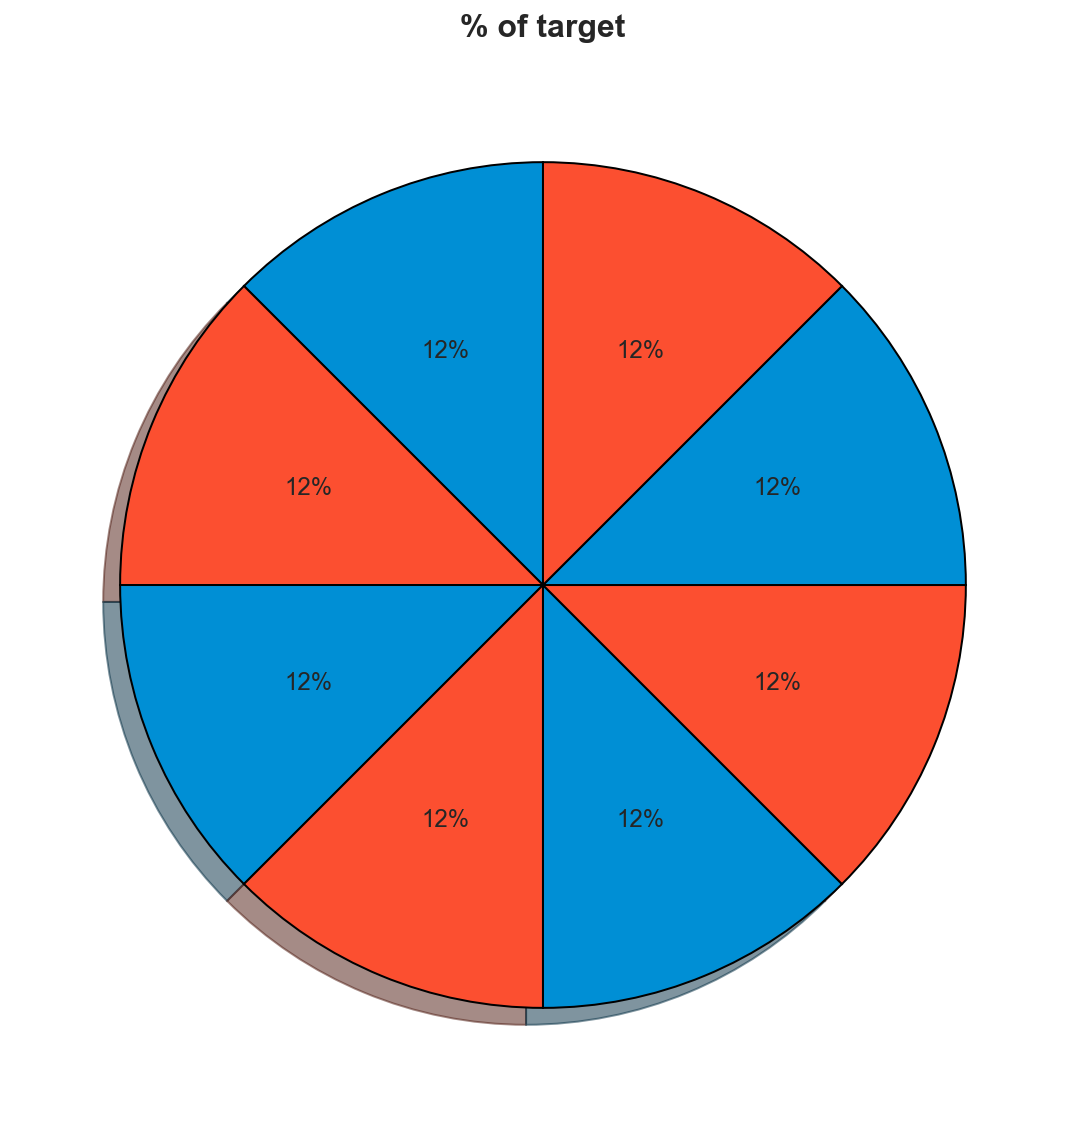

In [1087]:
target_count = raw_df[TARGETNAME].value_counts().to_frame().T

colors = ['#008fd5', '#fc4f30']
plt.figure(figsize=(8,8))
plt.title('% of target')
plt.tight_layout()
plt.pie(list(target_count.iloc[0].values), startangle=90, wedgeprops={'edgecolor': 'black'}, colors=colors, autopct='%1.f%%', shadow=True)
plt.legend(loc='best', fontsize='medium')
plt.show()

In [1088]:
X = raw_df.drop(['match_id'], axis=1)


In [1089]:
y = X.pop(TARGETNAME)

In [1090]:
X.fillna('', inplace=True)

In [1091]:
X.dtypes

augment0                    object
augment1                    object
augment2                    object
Set7_Assassin              float32
Set7_Bruiser               float32
                            ...   
TFT7_Aatrox_item1           object
TFT7_Aatrox_item2           object
TFT7_Senna_item1            object
TFT7_Senna_item2            object
TFT7_Heimerdinger_item2     object
Length: 265, dtype: object

In [1092]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

In [1093]:
X[numeric_cols] = X[numeric_cols].applymap(np.int64)

In [1094]:
matches_df = X.copy()
matches_df[TARGETNAME] = y

In [1095]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11528 entries, 0 to 11527
Columns: 265 entries, augment0 to TFT7_Heimerdinger_item2
dtypes: int64(87), object(178)
memory usage: 23.3+ MB


In [1096]:
X

,augment0,augment1,augment2,Set7_Assassin,Set7_Bruiser,Set7_Cavalier,Set7_Dragonmancer,Set7_Guild,Set7_Legend,Set7_Mirage,...,TFT7_Vladimir_item2,TFT7_Skarner_item0,TFT7_Skarner_item1,TFT7_Skarner_item2,TFT7_Kayn_item2,TFT7_Aatrox_item1,TFT7_Aatrox_item2,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Heimerdinger_item2
0,TFT6_Augment_TrueTwos,TFT6_Augment_CyberneticImplants2,TFT6_Augment_SecondWind2,1,1,2,0,3,0,0,...,None,None,None,None,None,None,None,None,None,None
1,TFT6_Augment_PortableForge,TFT6_Augment_SalvageBin,TFT6_Augment_TargetDummies,0,0,0,2,0,0,0,...,None,None,None,None,None,None,None,None,None,None
2,TFT7_Augment_AssassinEmblem,TFT6_Augment_TradeSectorPlus,TFT7_Augment_ScalescornEmblem,3,1,0,0,1,0,0,...,None,None,None,None,None,None,None,None,None,None
3,TFT7_Augment_SwiftshotPressTheAttack,TFT6_Augment_RichGetRicherPlus,TFT7_Augment_BestFriends2,1,1,1,0,3,0,0,...,None,None,None,None,None,None,None,None,None,None
4,TFT7_Augment_PandorasBench,TFT7_Augment_MikaelsGift,TFT6_Augment_SalvageBin,2,1,0,0,2,0,0,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11523,TFT6_Augment_PortableForge,TFT7_Augment_AxiomArc2,TFT6_Augment_FuturePeepers,0,0,0,0,1,0,0,...,None,None,None,None,None,None,None,None,None,None
11524,TFT6_Augment_TrueTwos,TFT6_Augment_PortableForge,TFT7_Augment_GuardianEmblem,0,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
11525,TFT6_Augment_TargetDummies,TFT6_Augment_LudensEcho2,TFT6_Augment_PortableForge,0,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
11526,TFT6_Augment_ClearMind,TFT6_Augment_ComponentGrabBag,TFT7_Augment_AssassinCutthroat,2,1,0,0,1,0,0,...,None,None,None,None,None,None,None,None,None,None


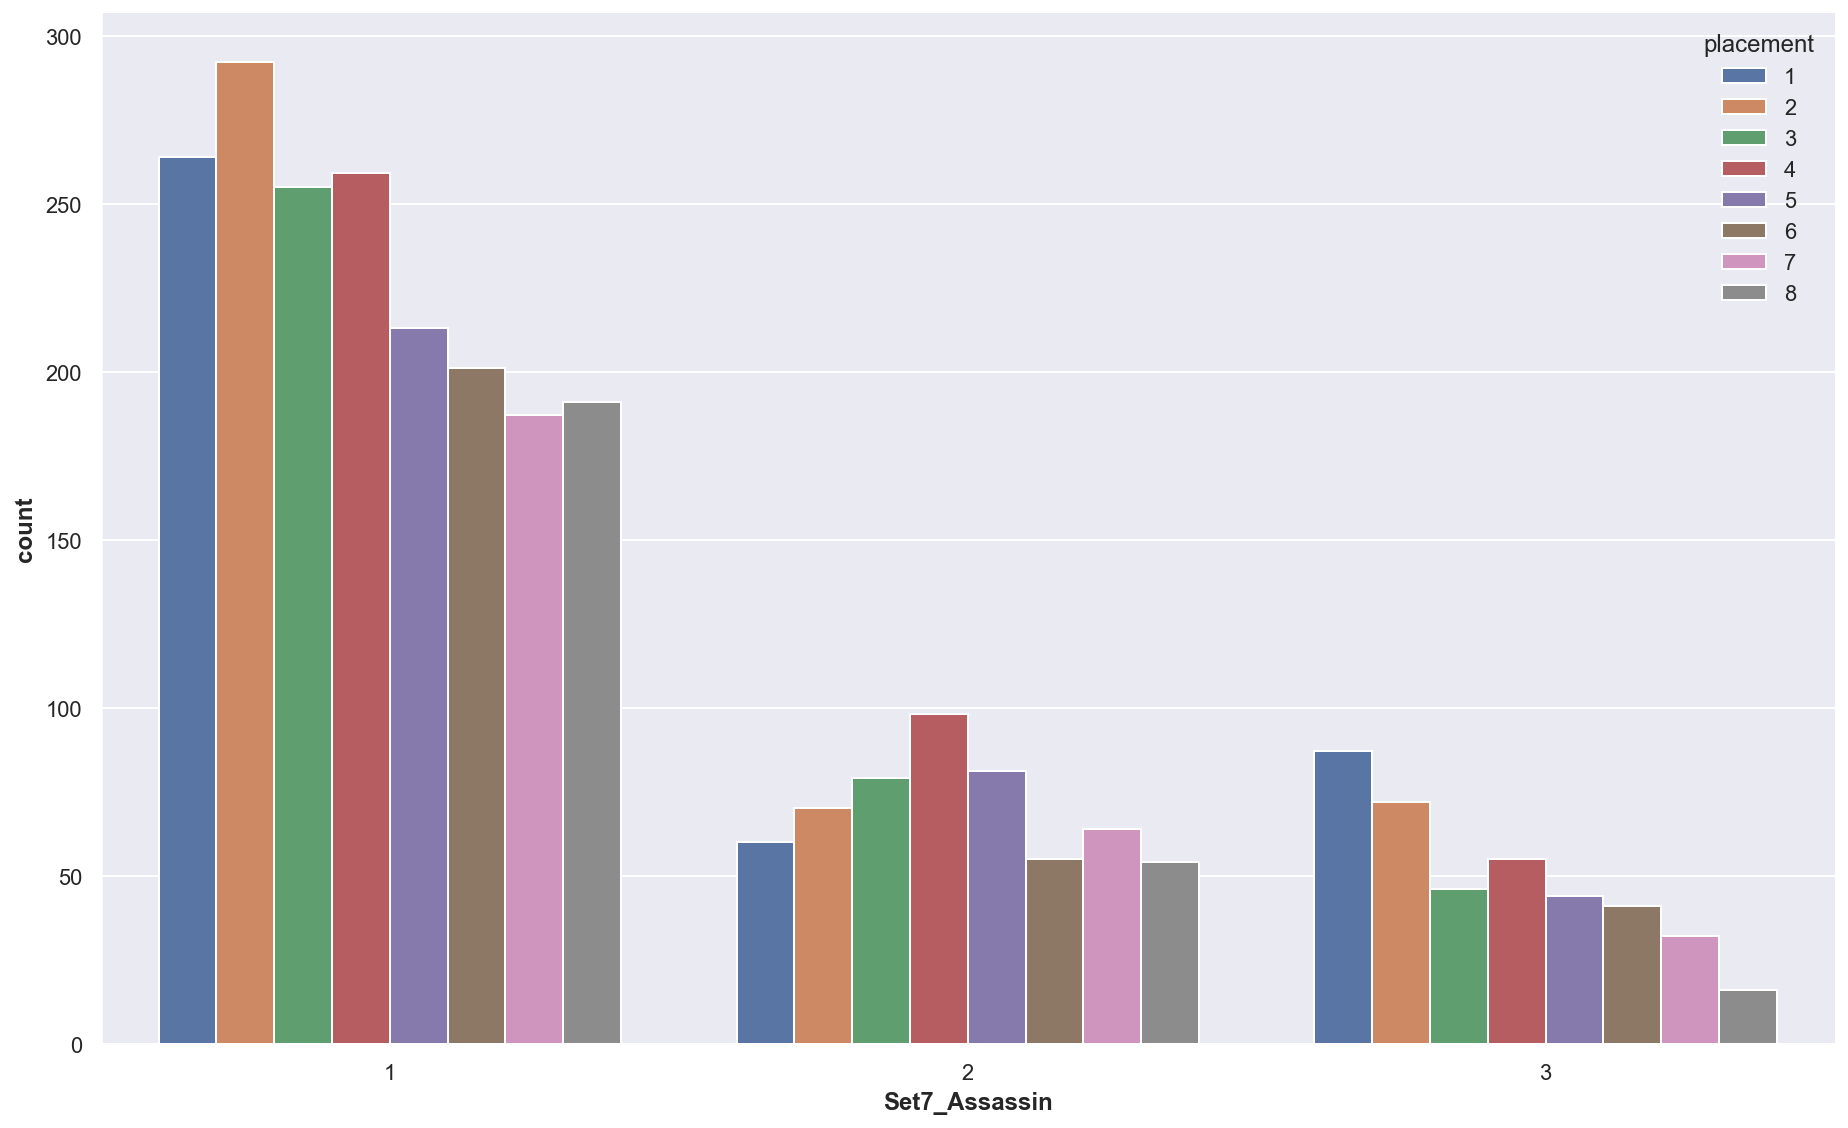

In [1097]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Assassin']>0], x='Set7_Assassin', hue=TARGETNAME)
sns.despine()

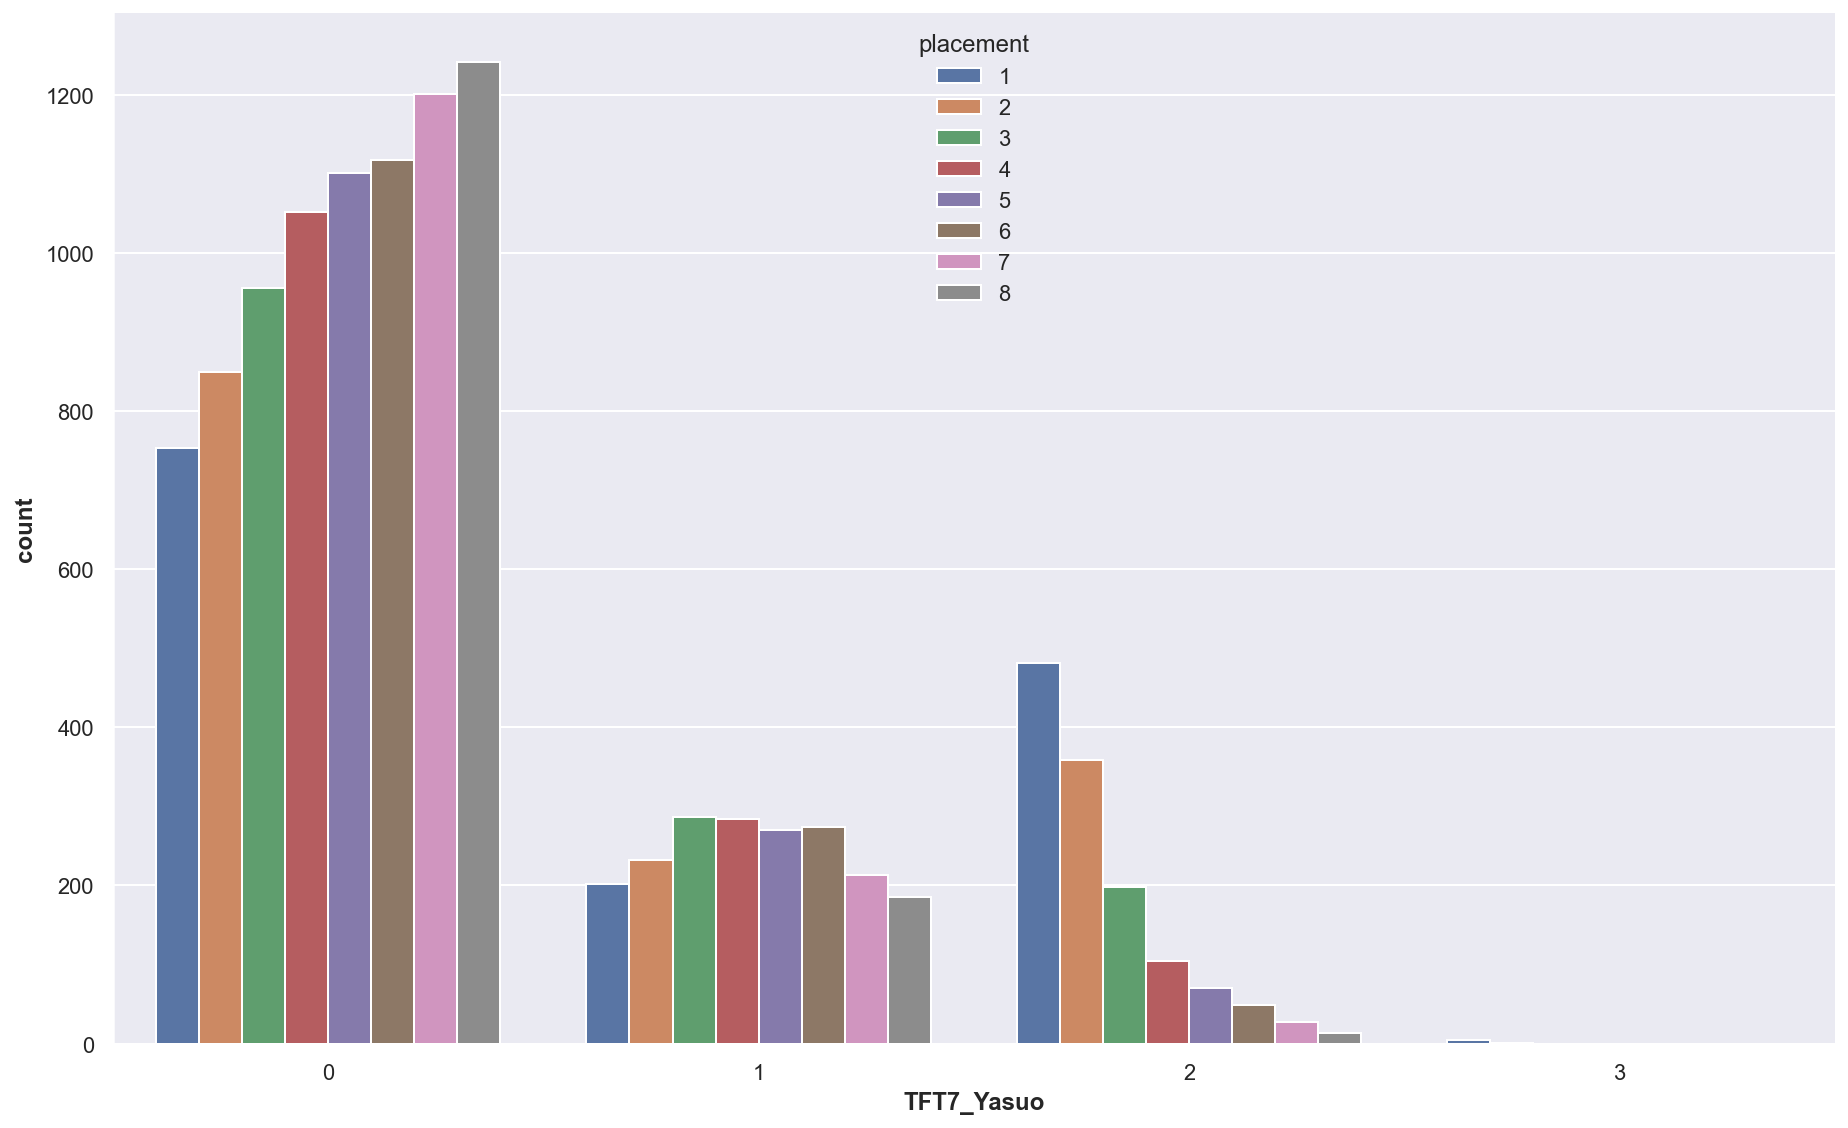

In [1098]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='TFT7_Yasuo', hue=TARGETNAME)
sns.despine()

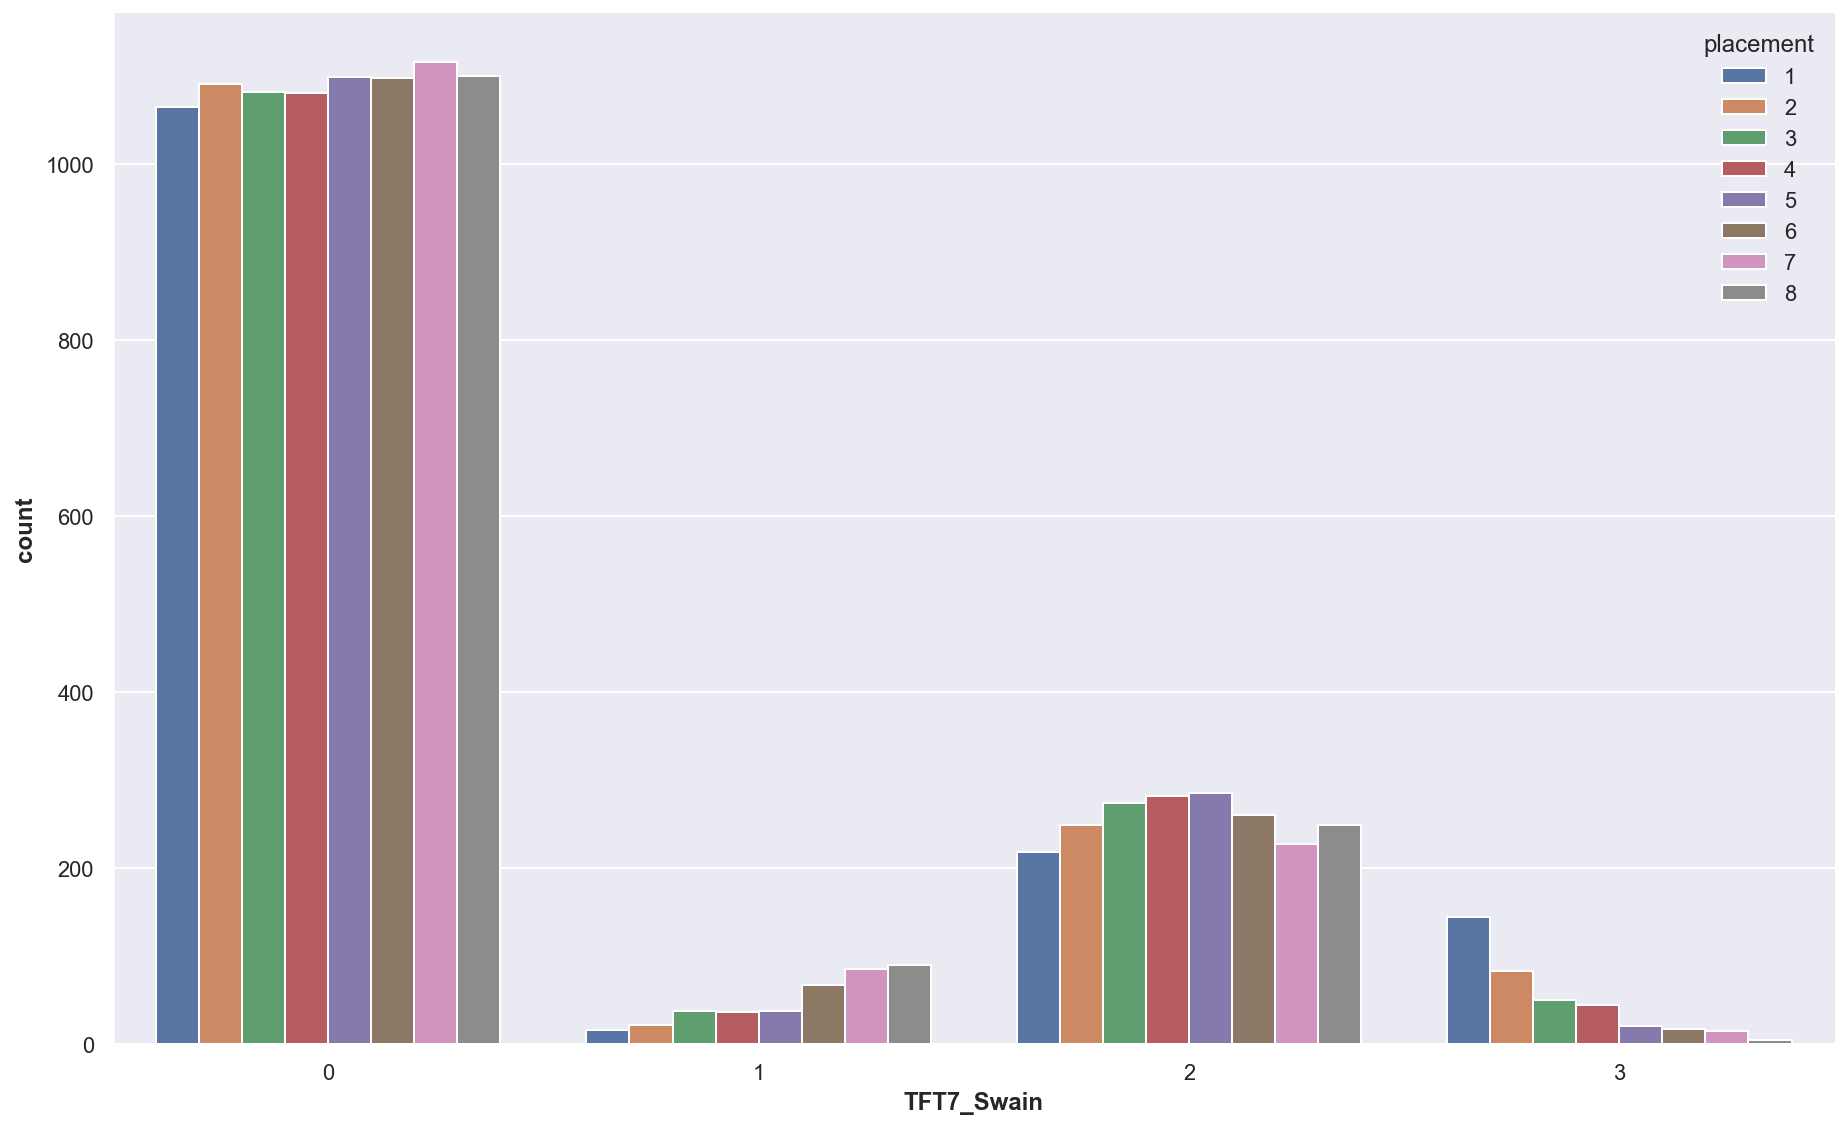

In [1099]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='TFT7_Swain', hue=TARGETNAME)
sns.despine()

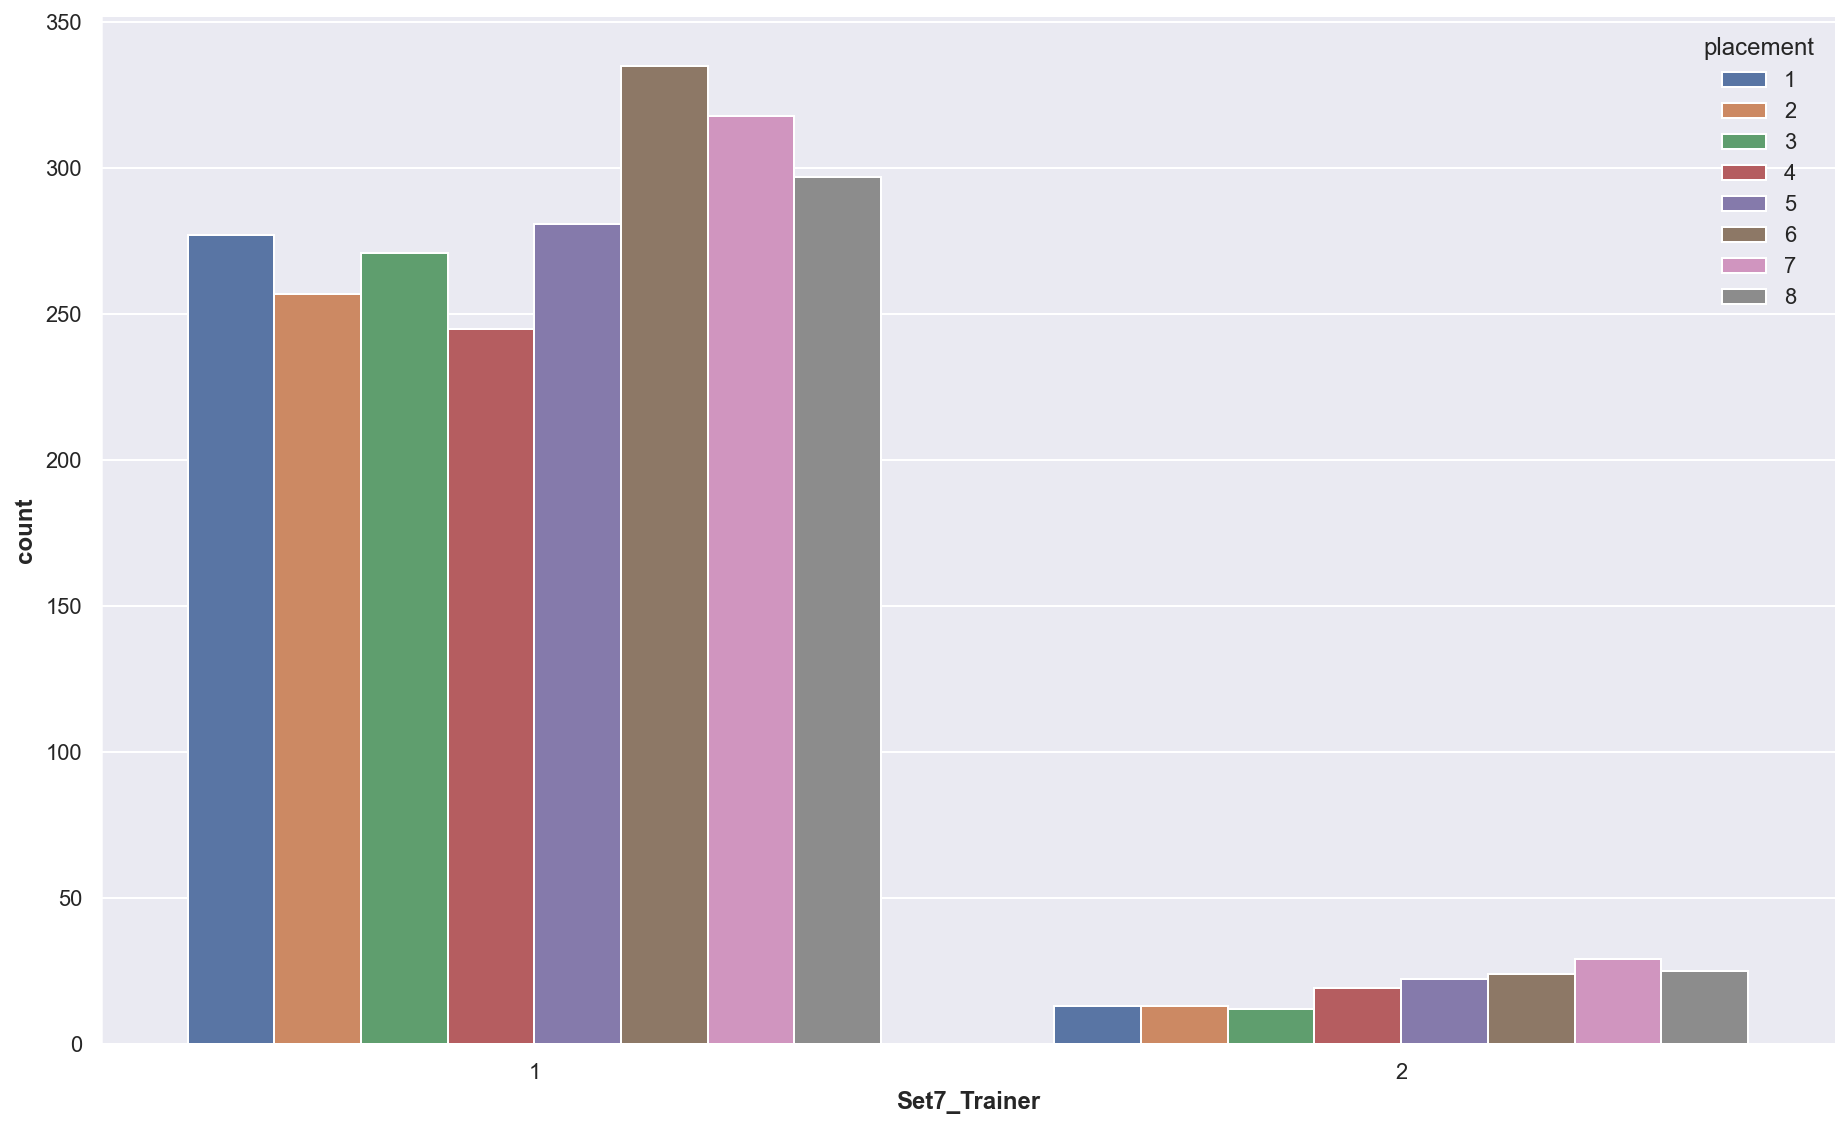

In [1100]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Trainer']>0], x='Set7_Trainer', hue=TARGETNAME)
sns.despine()

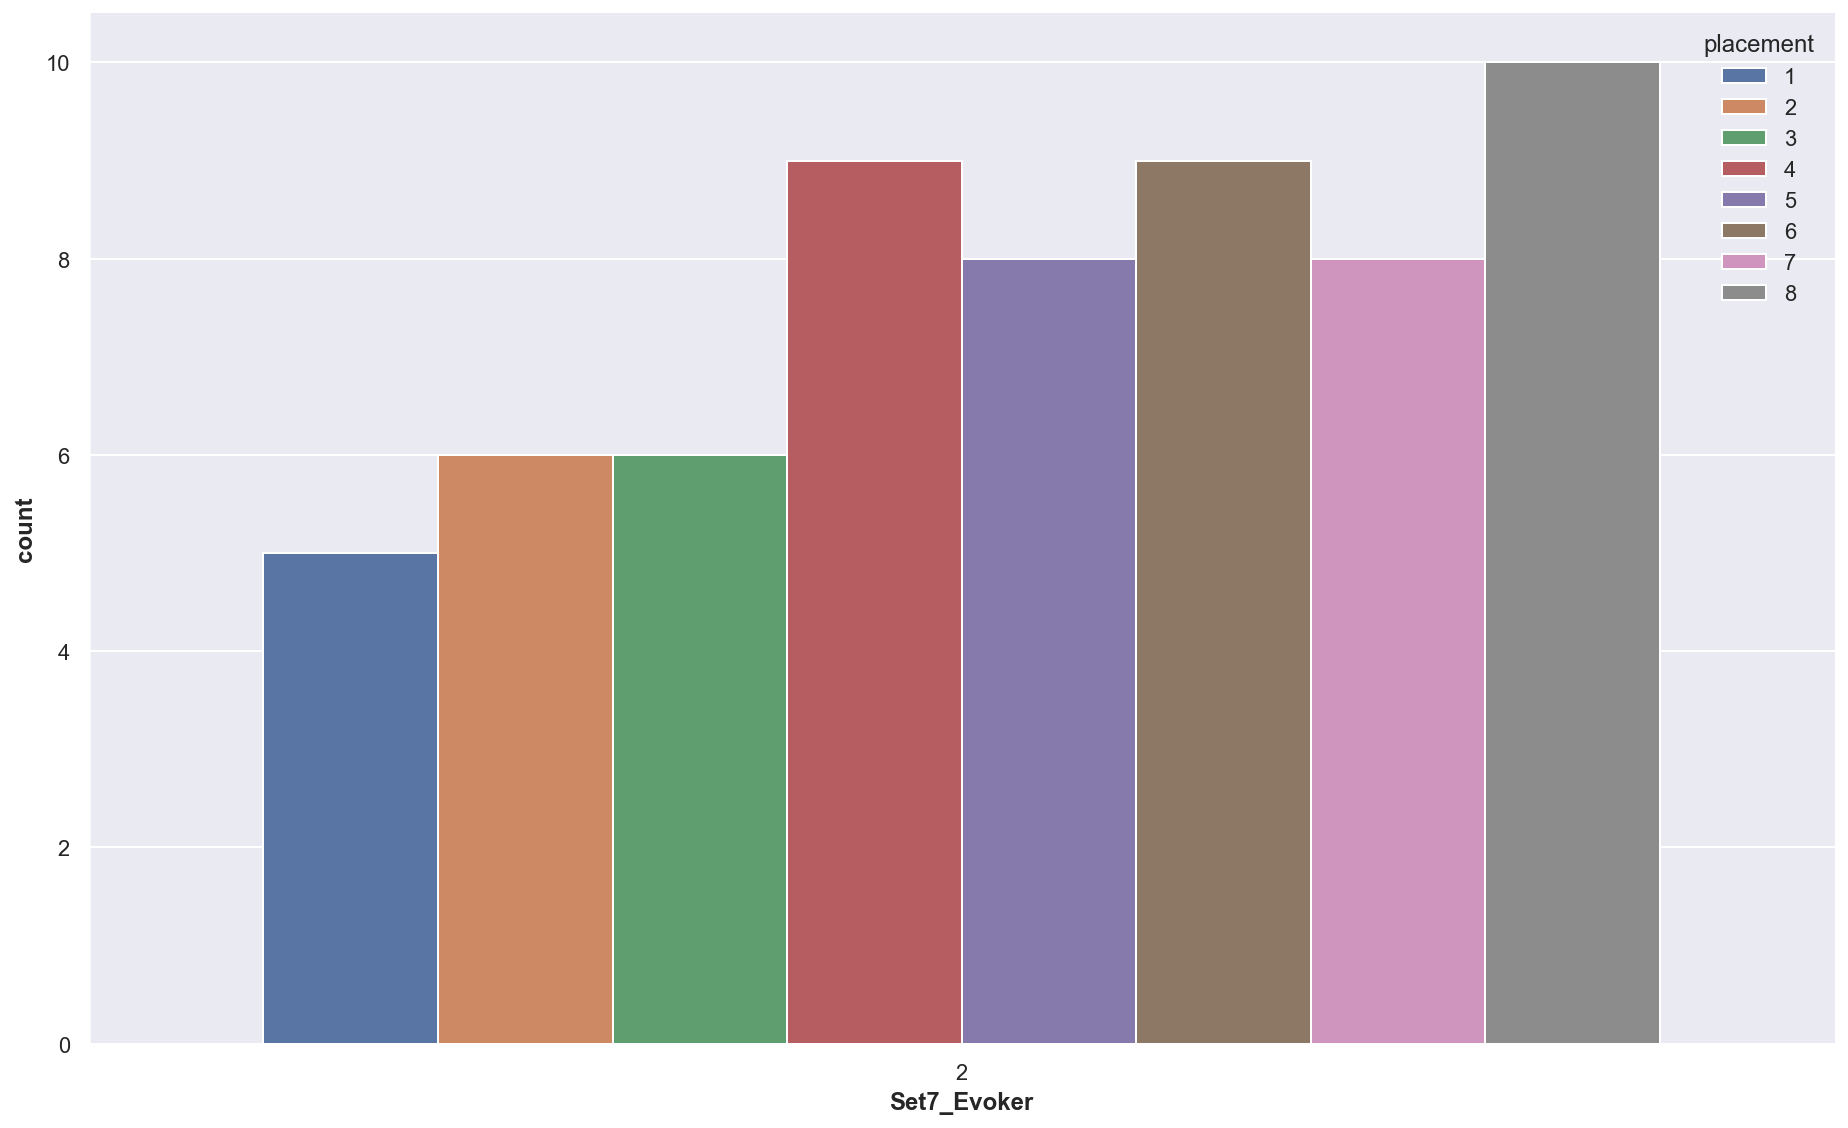

In [1101]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Evoker']>1], x='Set7_Evoker', hue=TARGETNAME)
sns.despine()

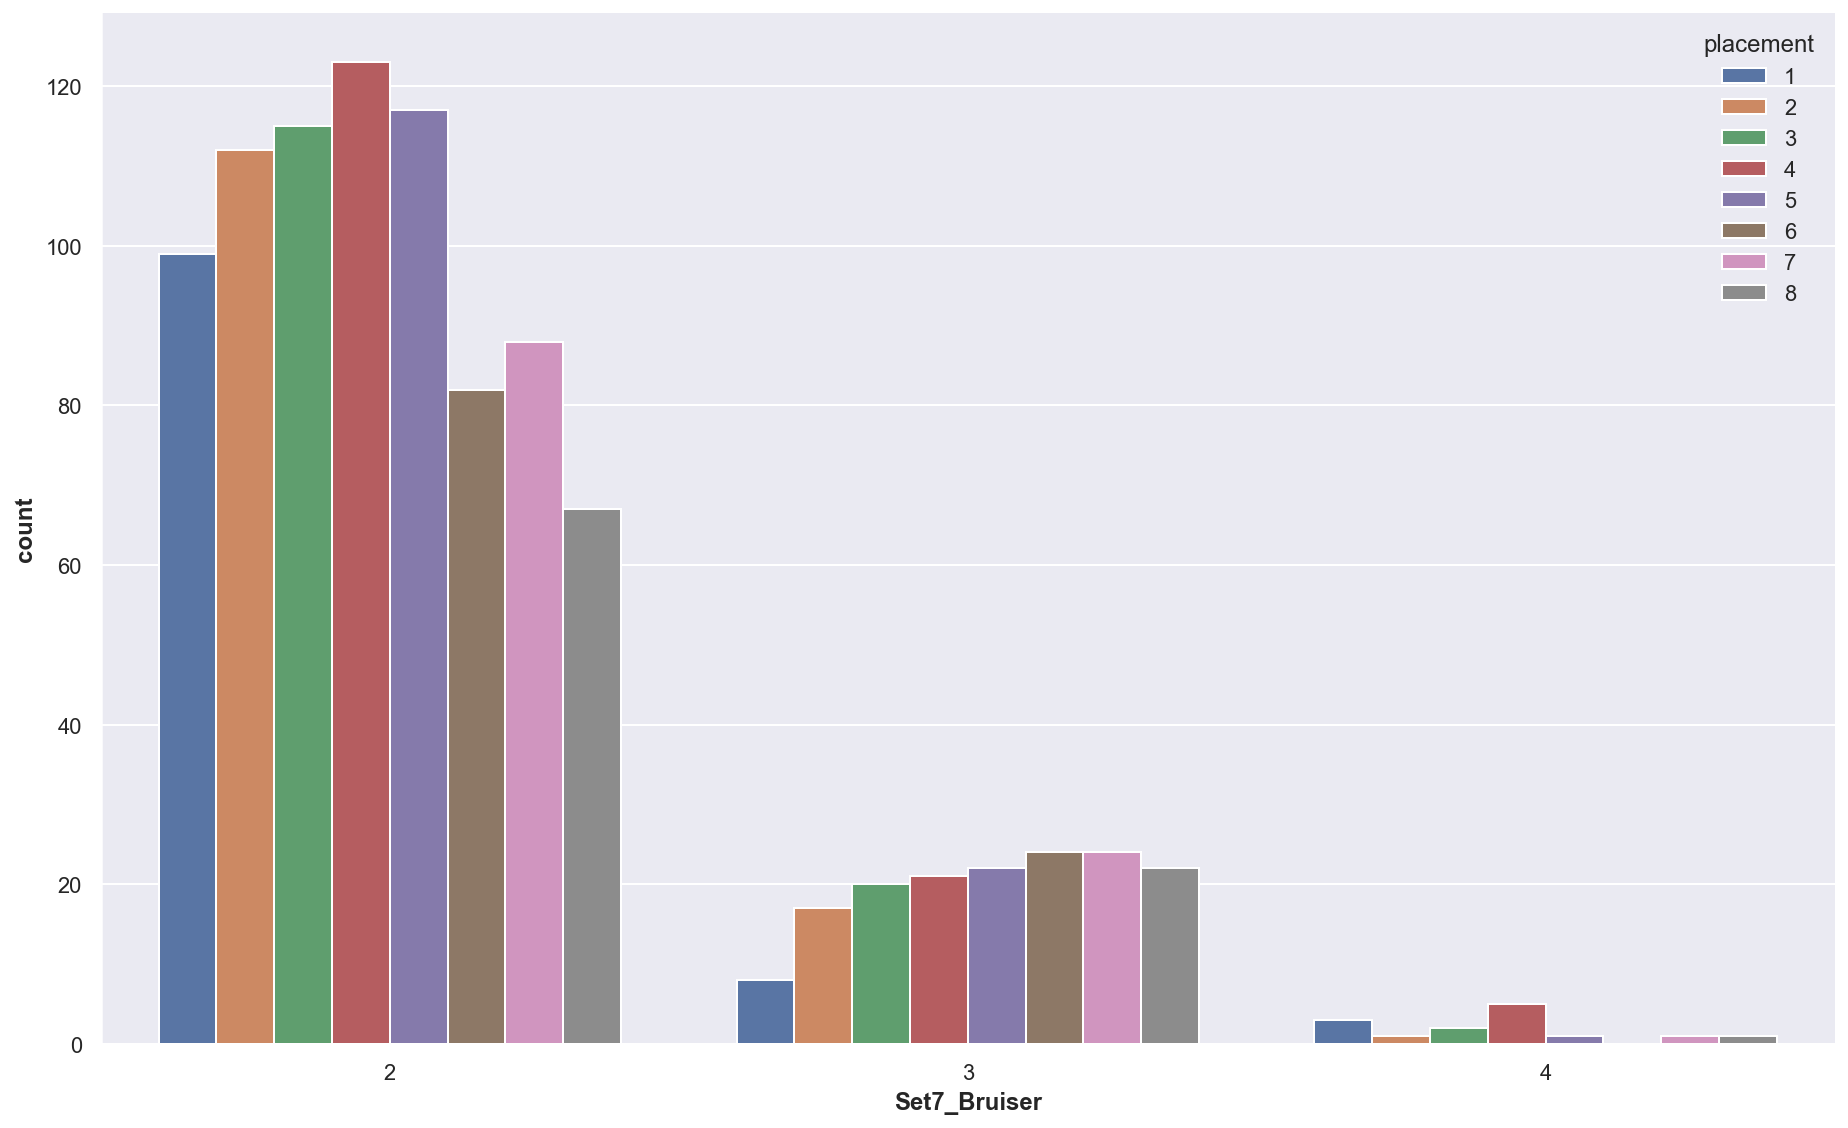

In [1102]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Bruiser']>1], x='Set7_Bruiser', hue=TARGETNAME)
sns.despine()

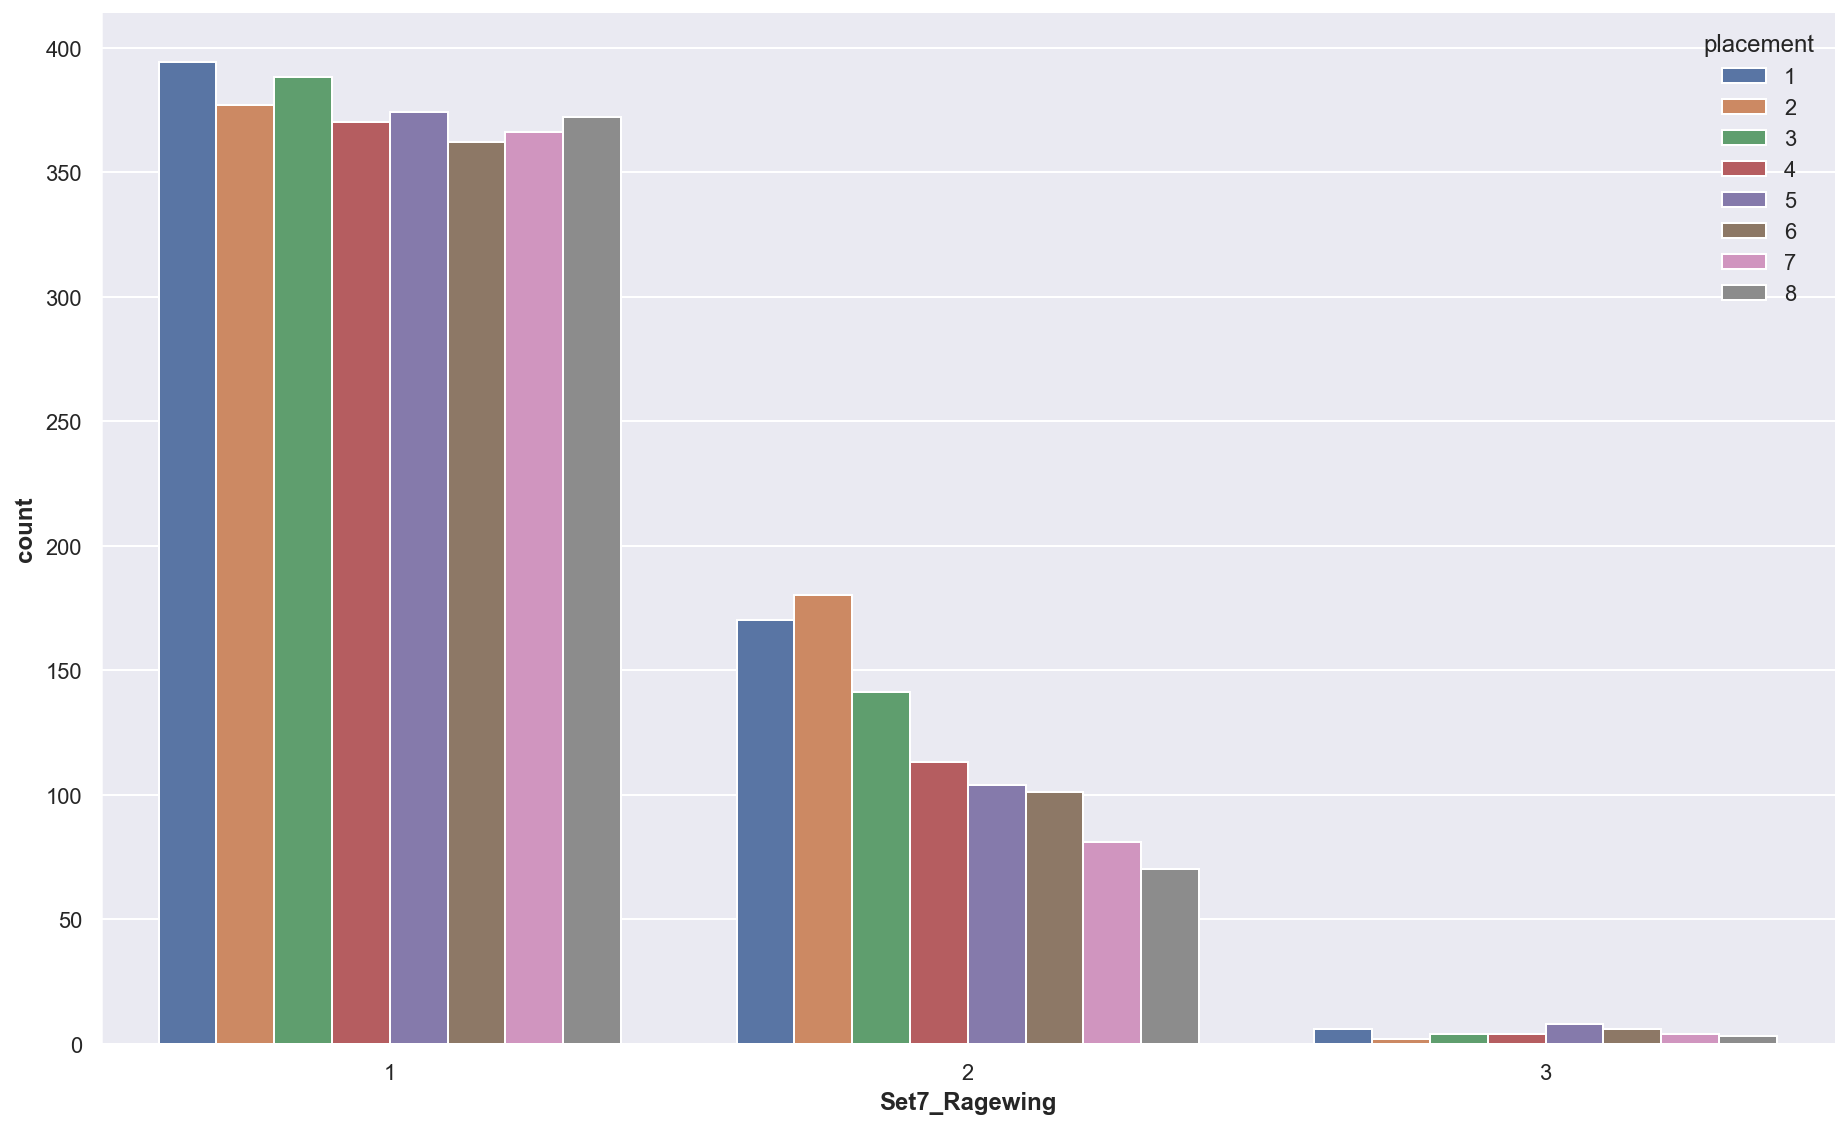

In [1103]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Ragewing']>0], x='Set7_Ragewing', hue=TARGETNAME)
sns.despine()

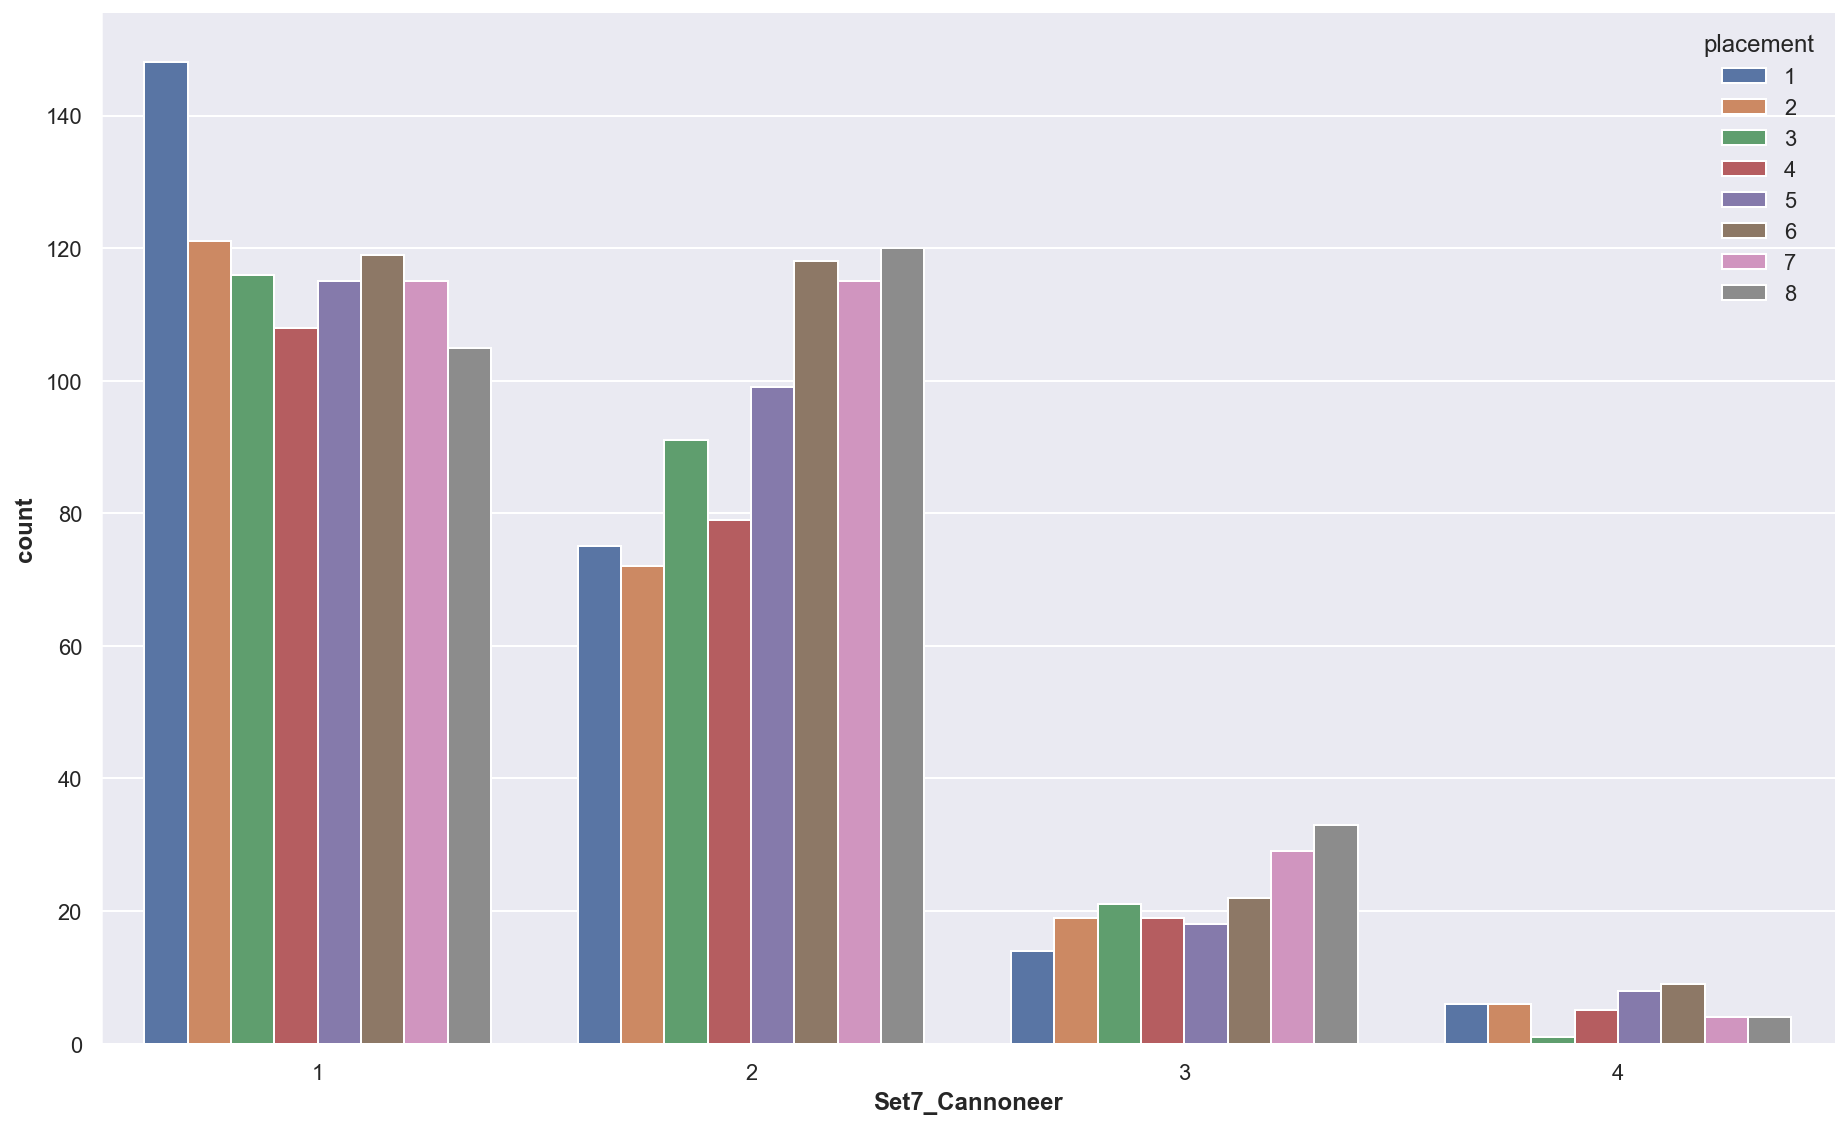

In [1104]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Cannoneer']>0], x='Set7_Cannoneer', hue=TARGETNAME)
sns.despine()

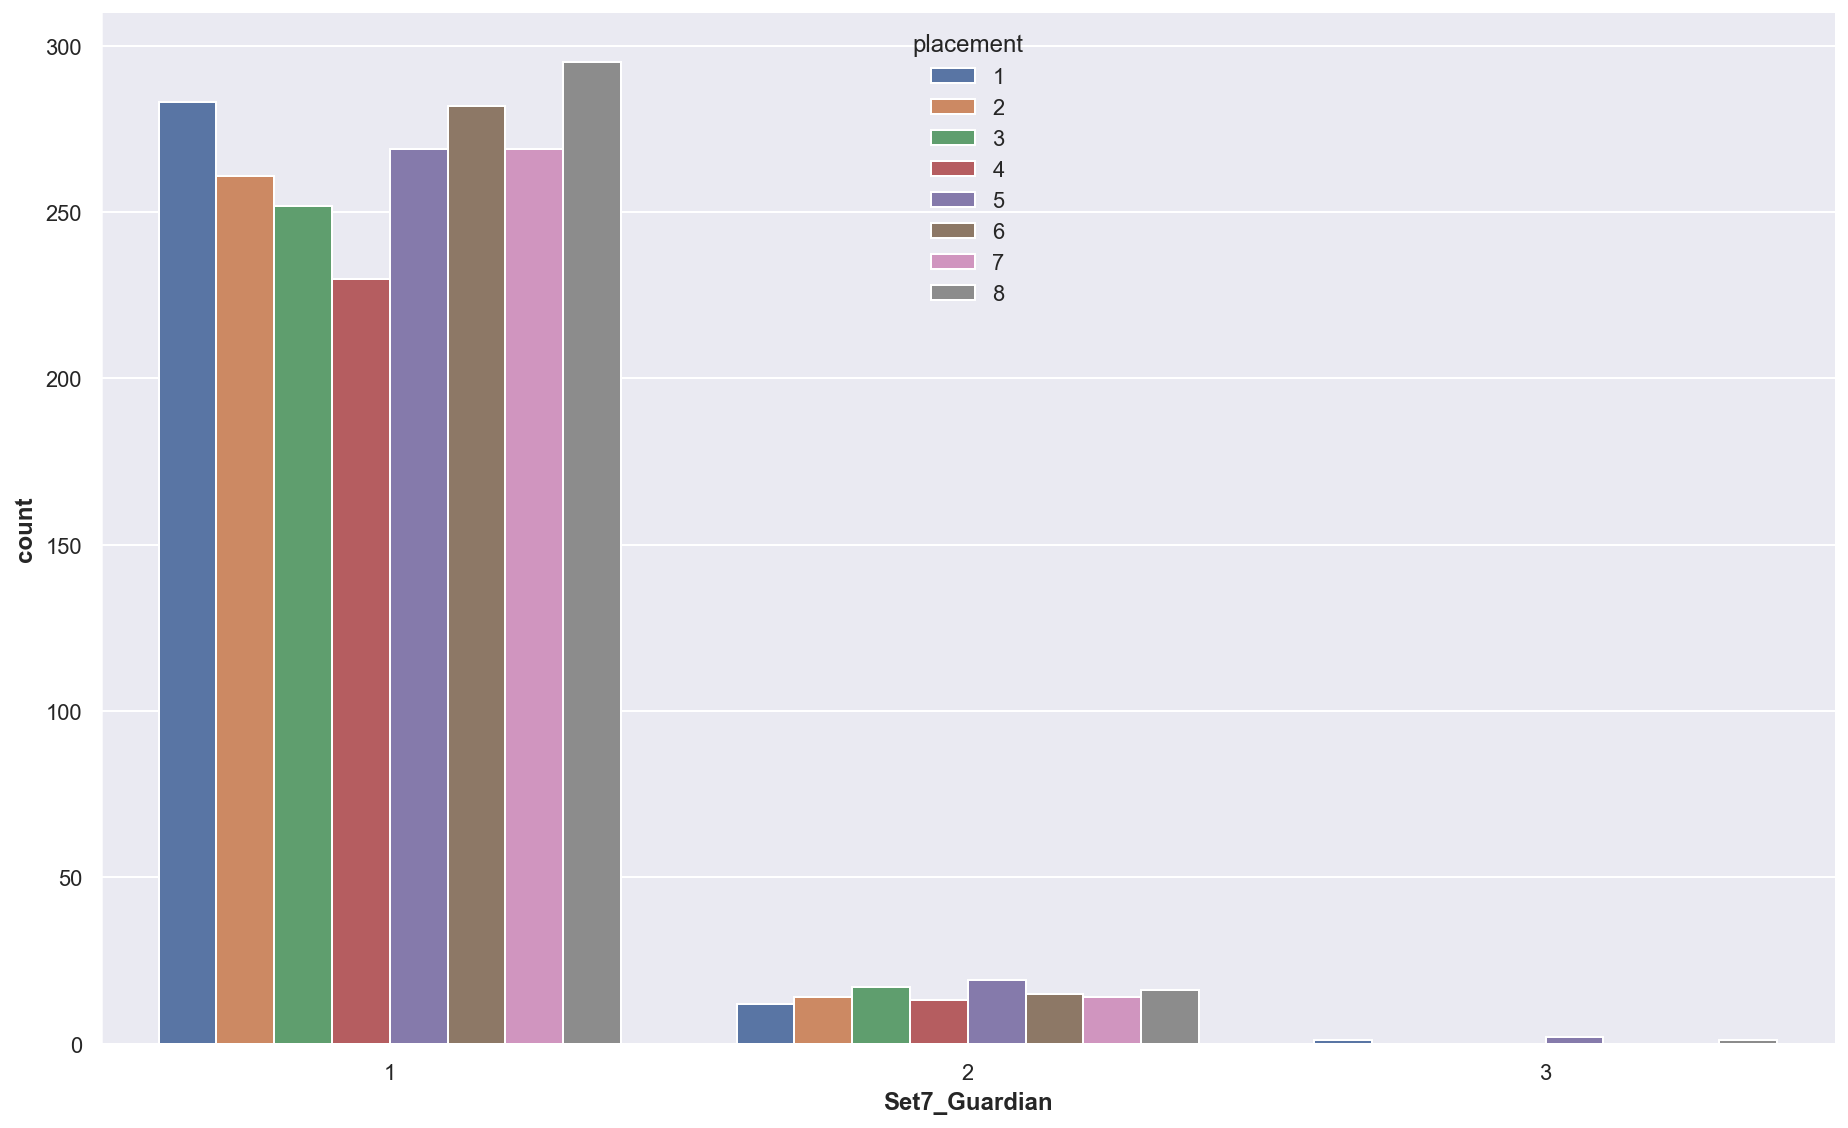

In [1105]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Guardian']>0], x='Set7_Guardian', hue=TARGETNAME)
sns.despine()

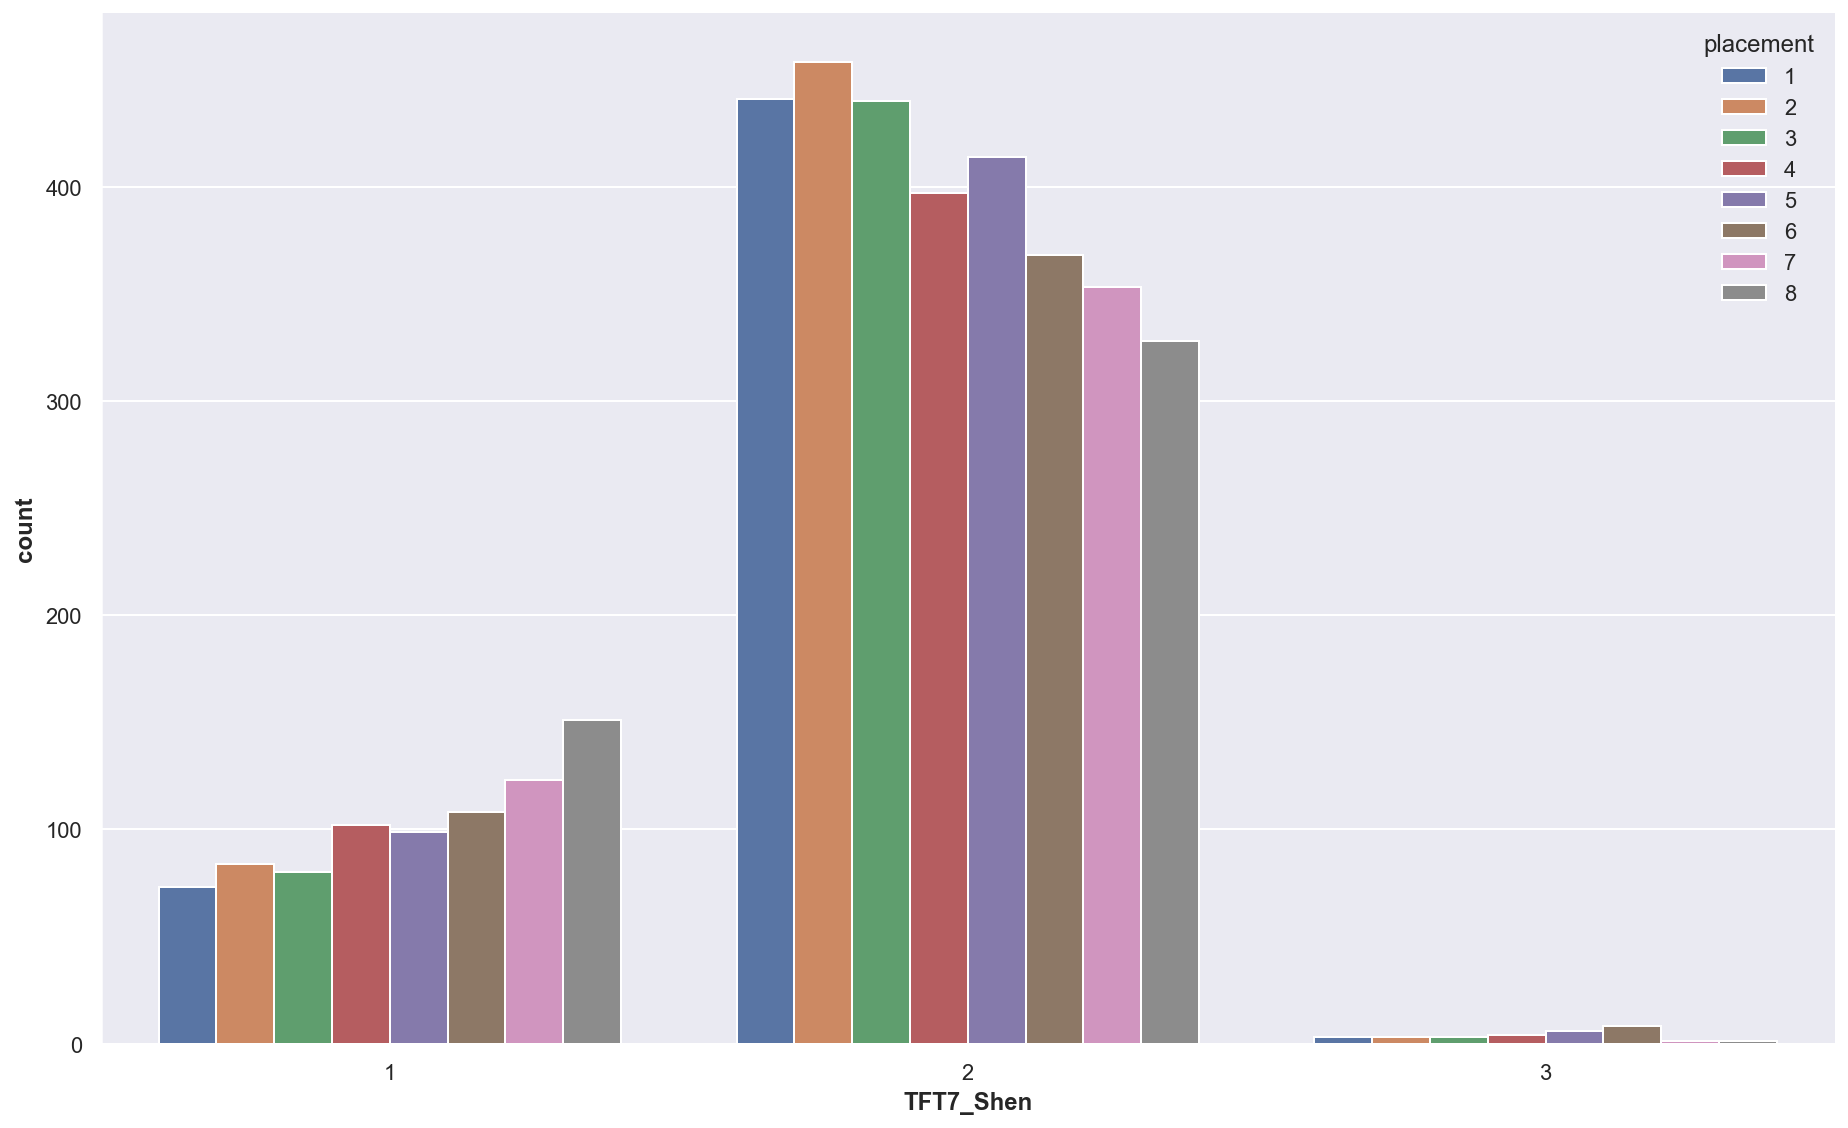

In [1106]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['TFT7_Shen']>0], x='TFT7_Shen', hue=TARGETNAME)
sns.despine()

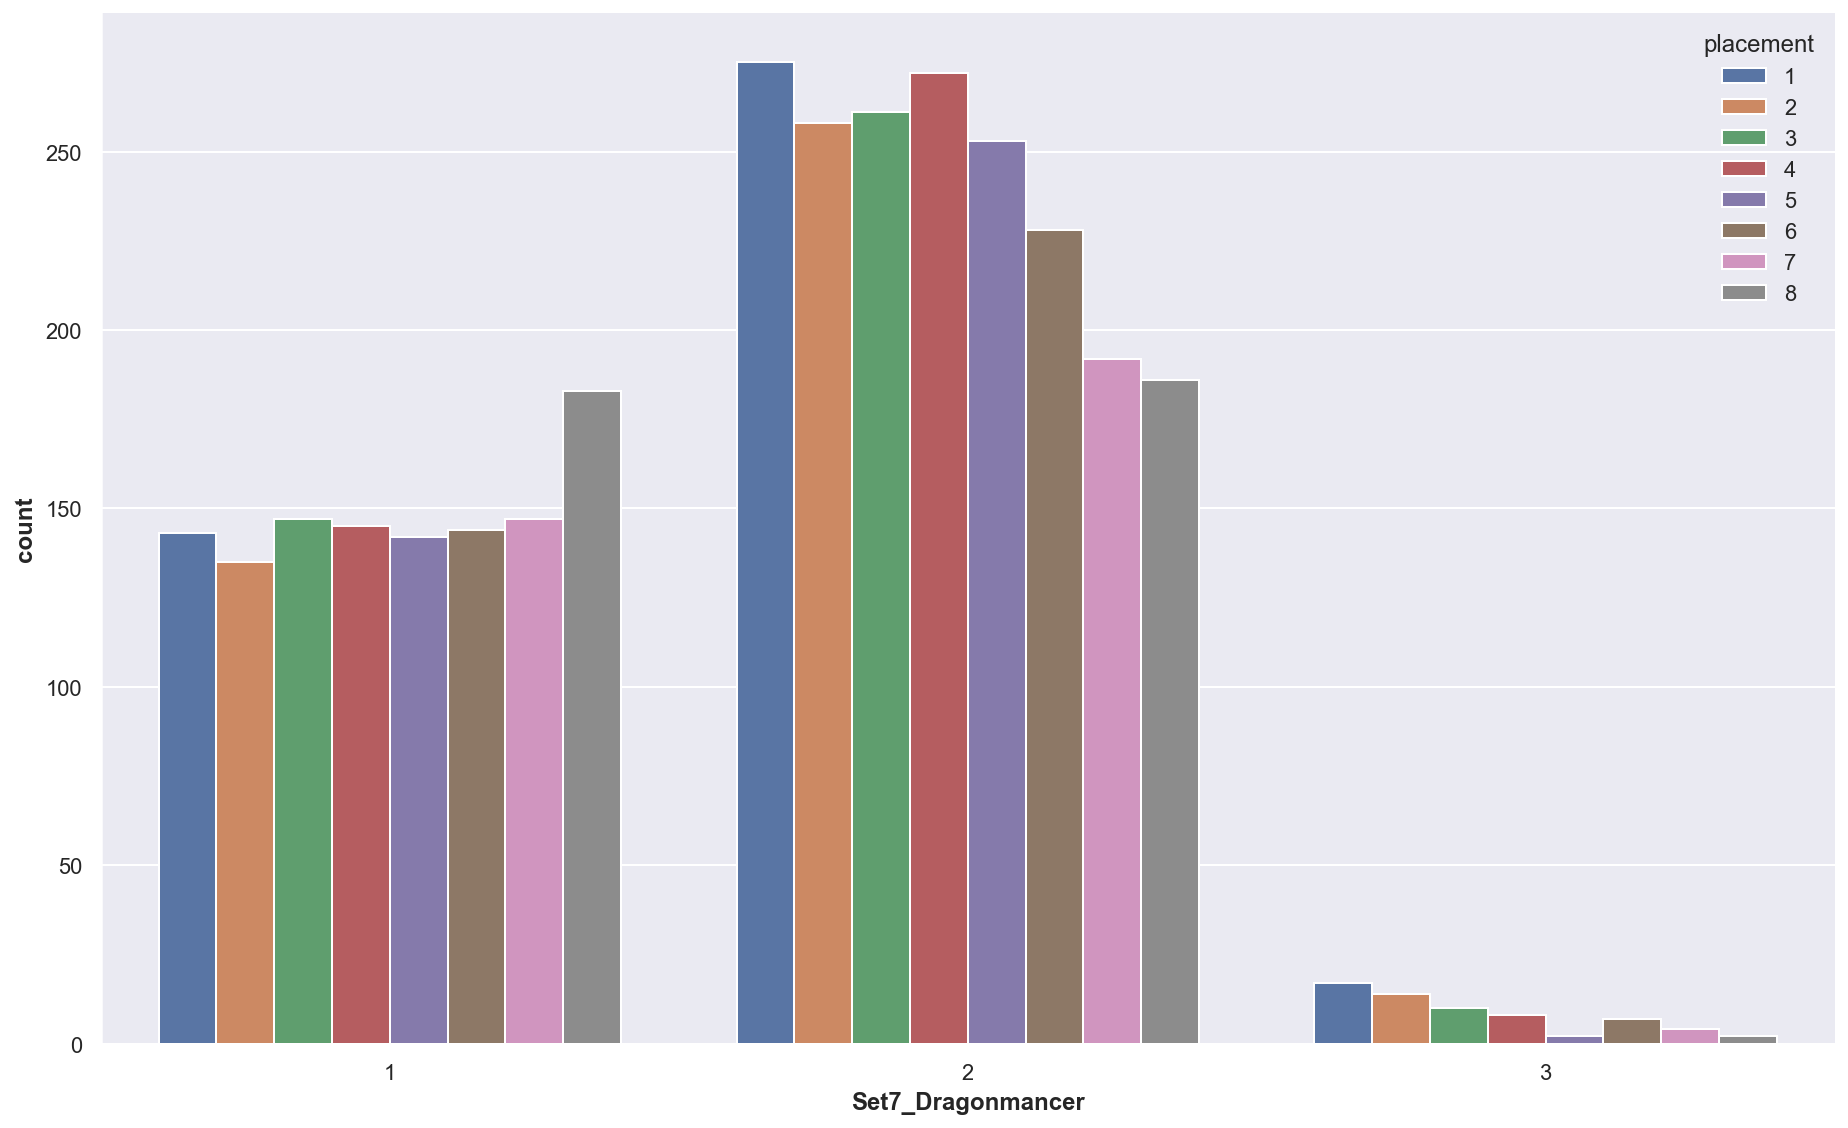

In [1107]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Dragonmancer']>0], x='Set7_Dragonmancer', hue=TARGETNAME)
sns.despine()

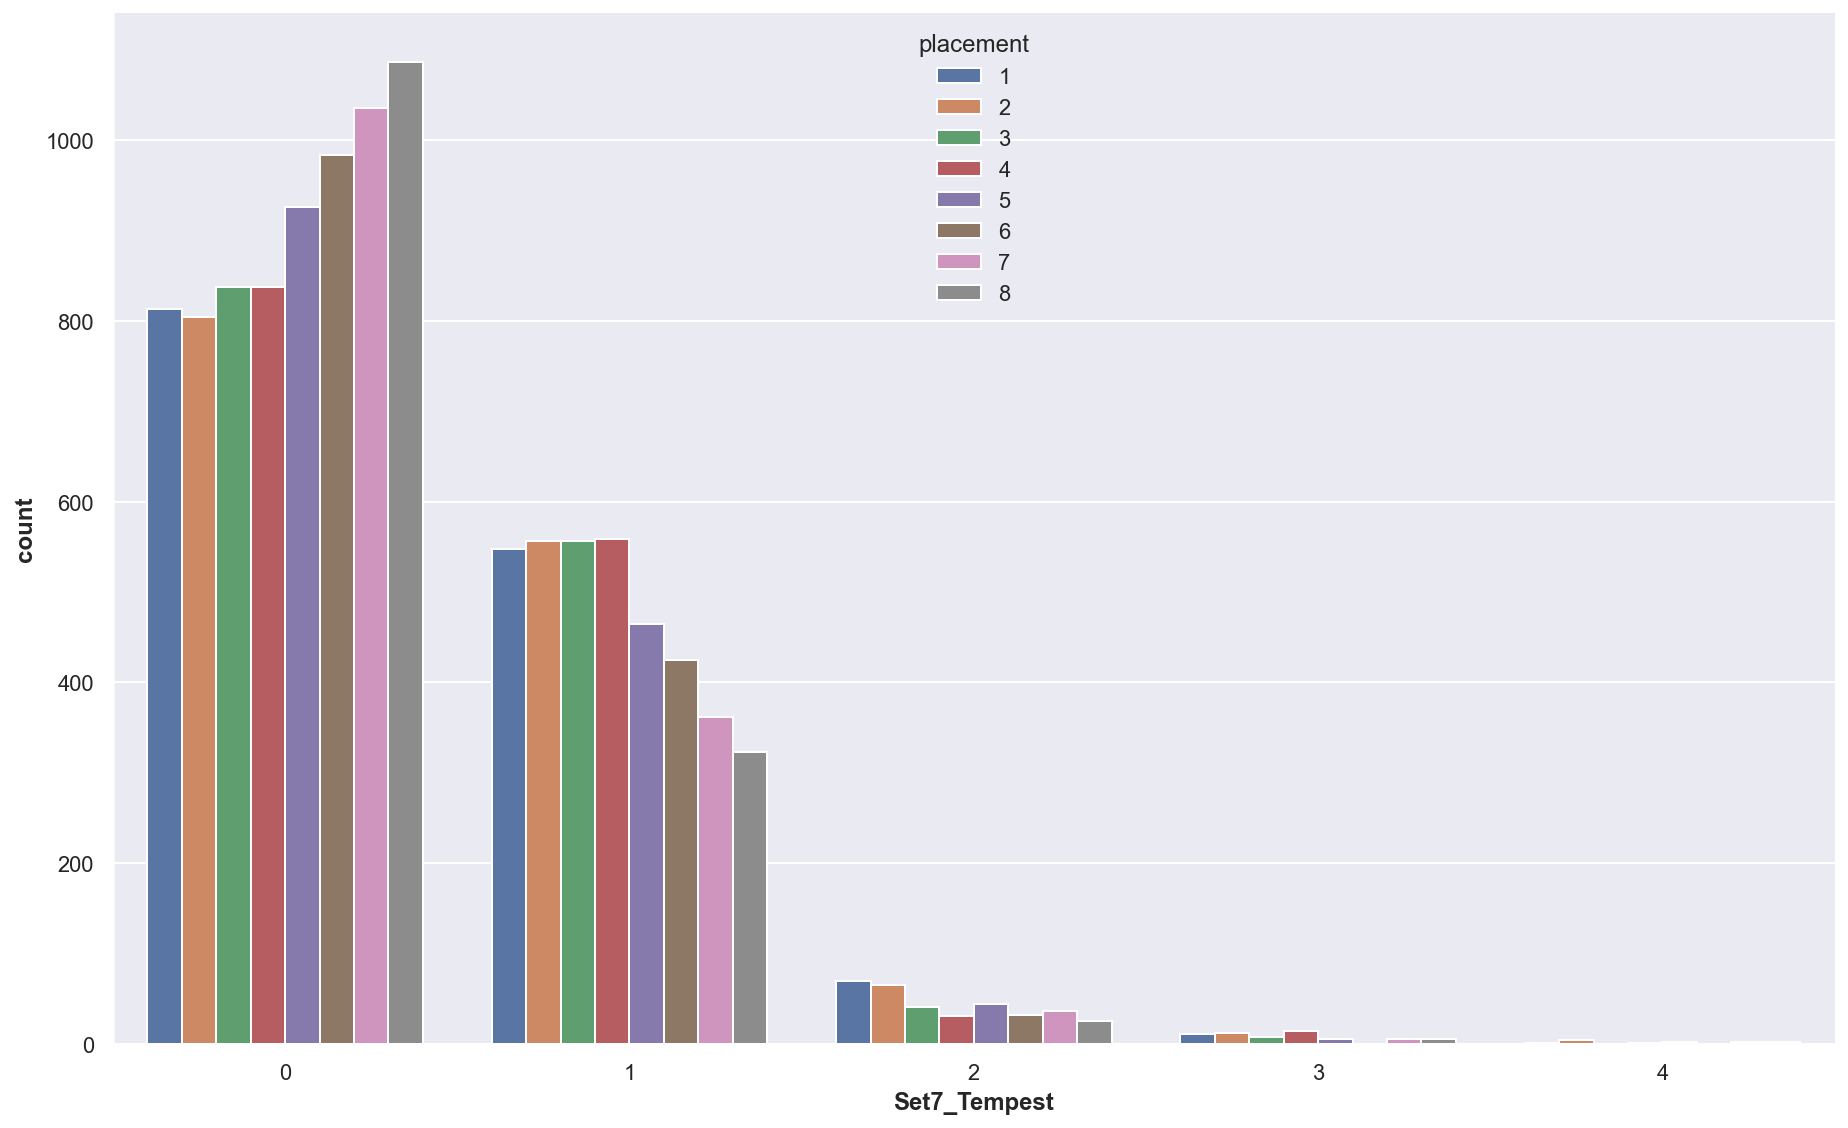

In [1108]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='Set7_Tempest', hue=TARGETNAME)
sns.despine()

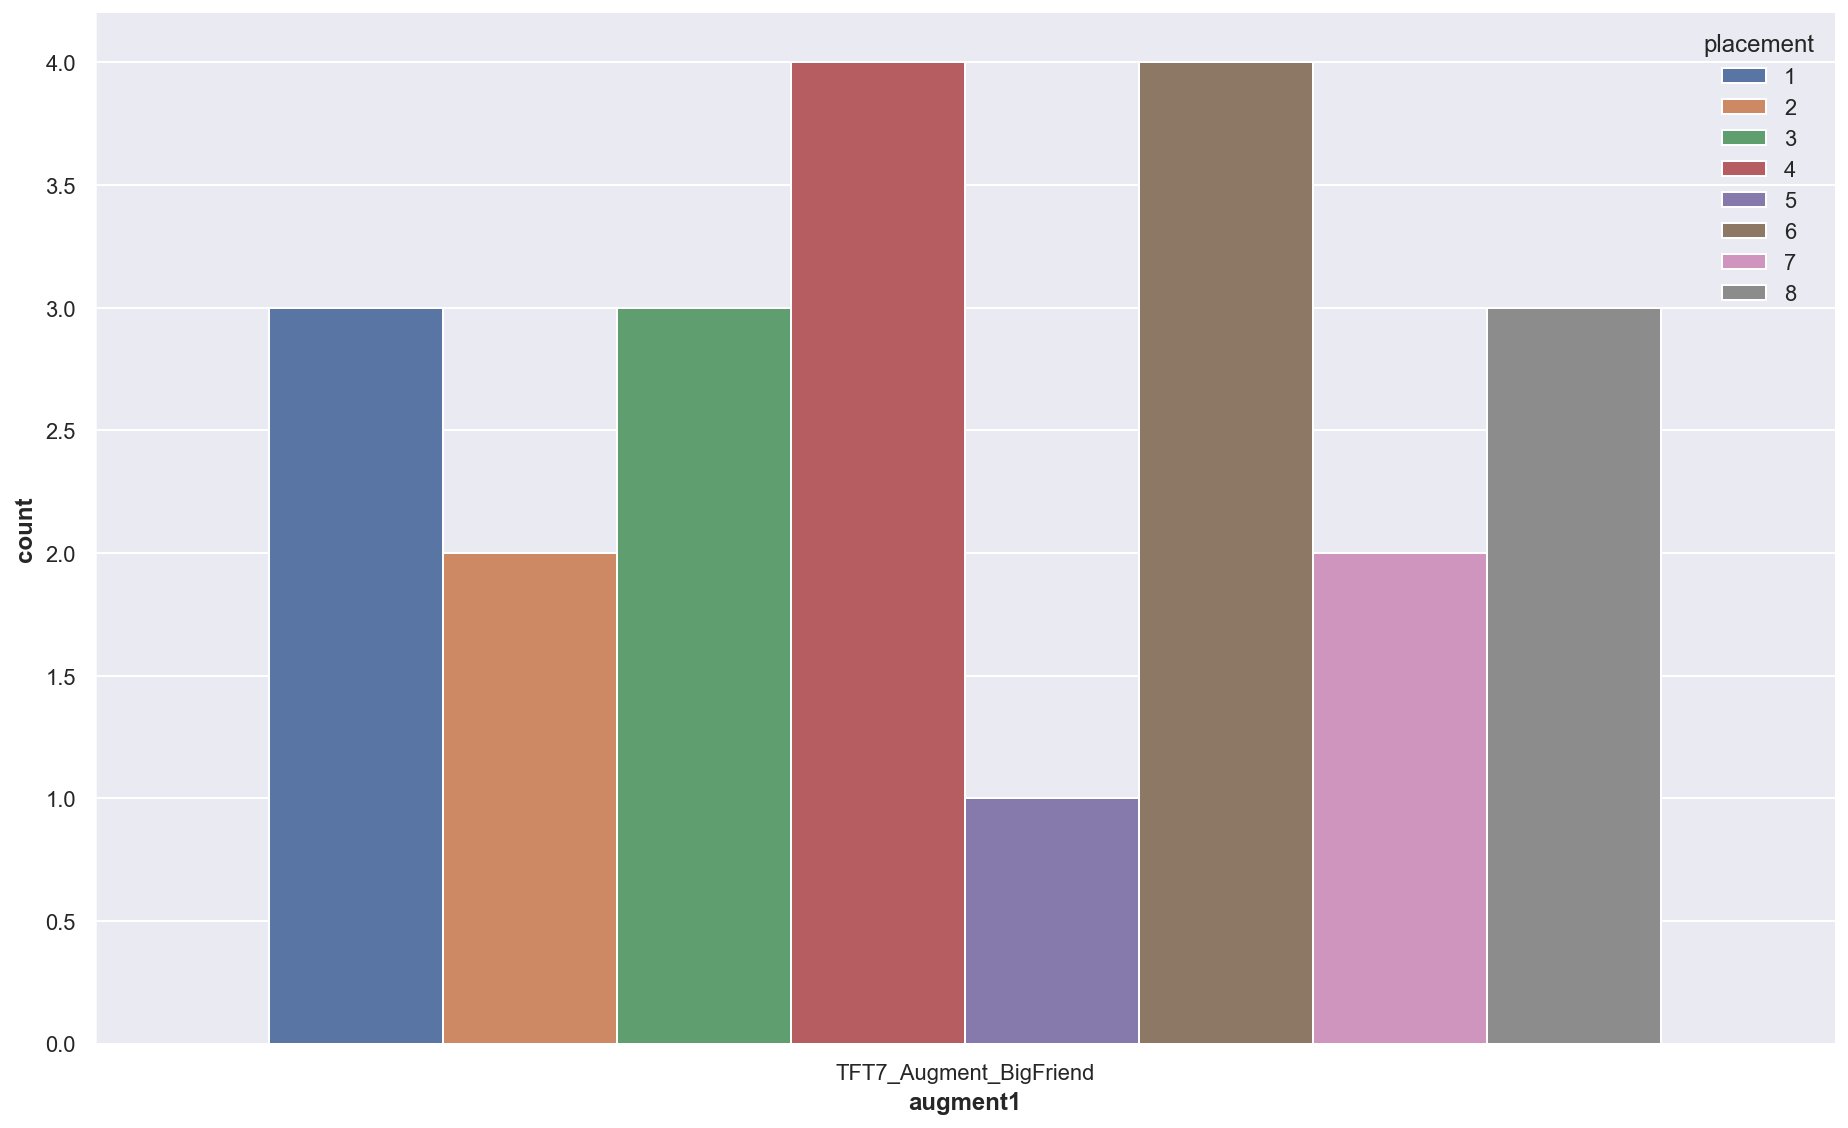

In [1109]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['augment1']=='TFT7_Augment_BigFriend'], x='augment1', hue=TARGETNAME)
sns.despine()

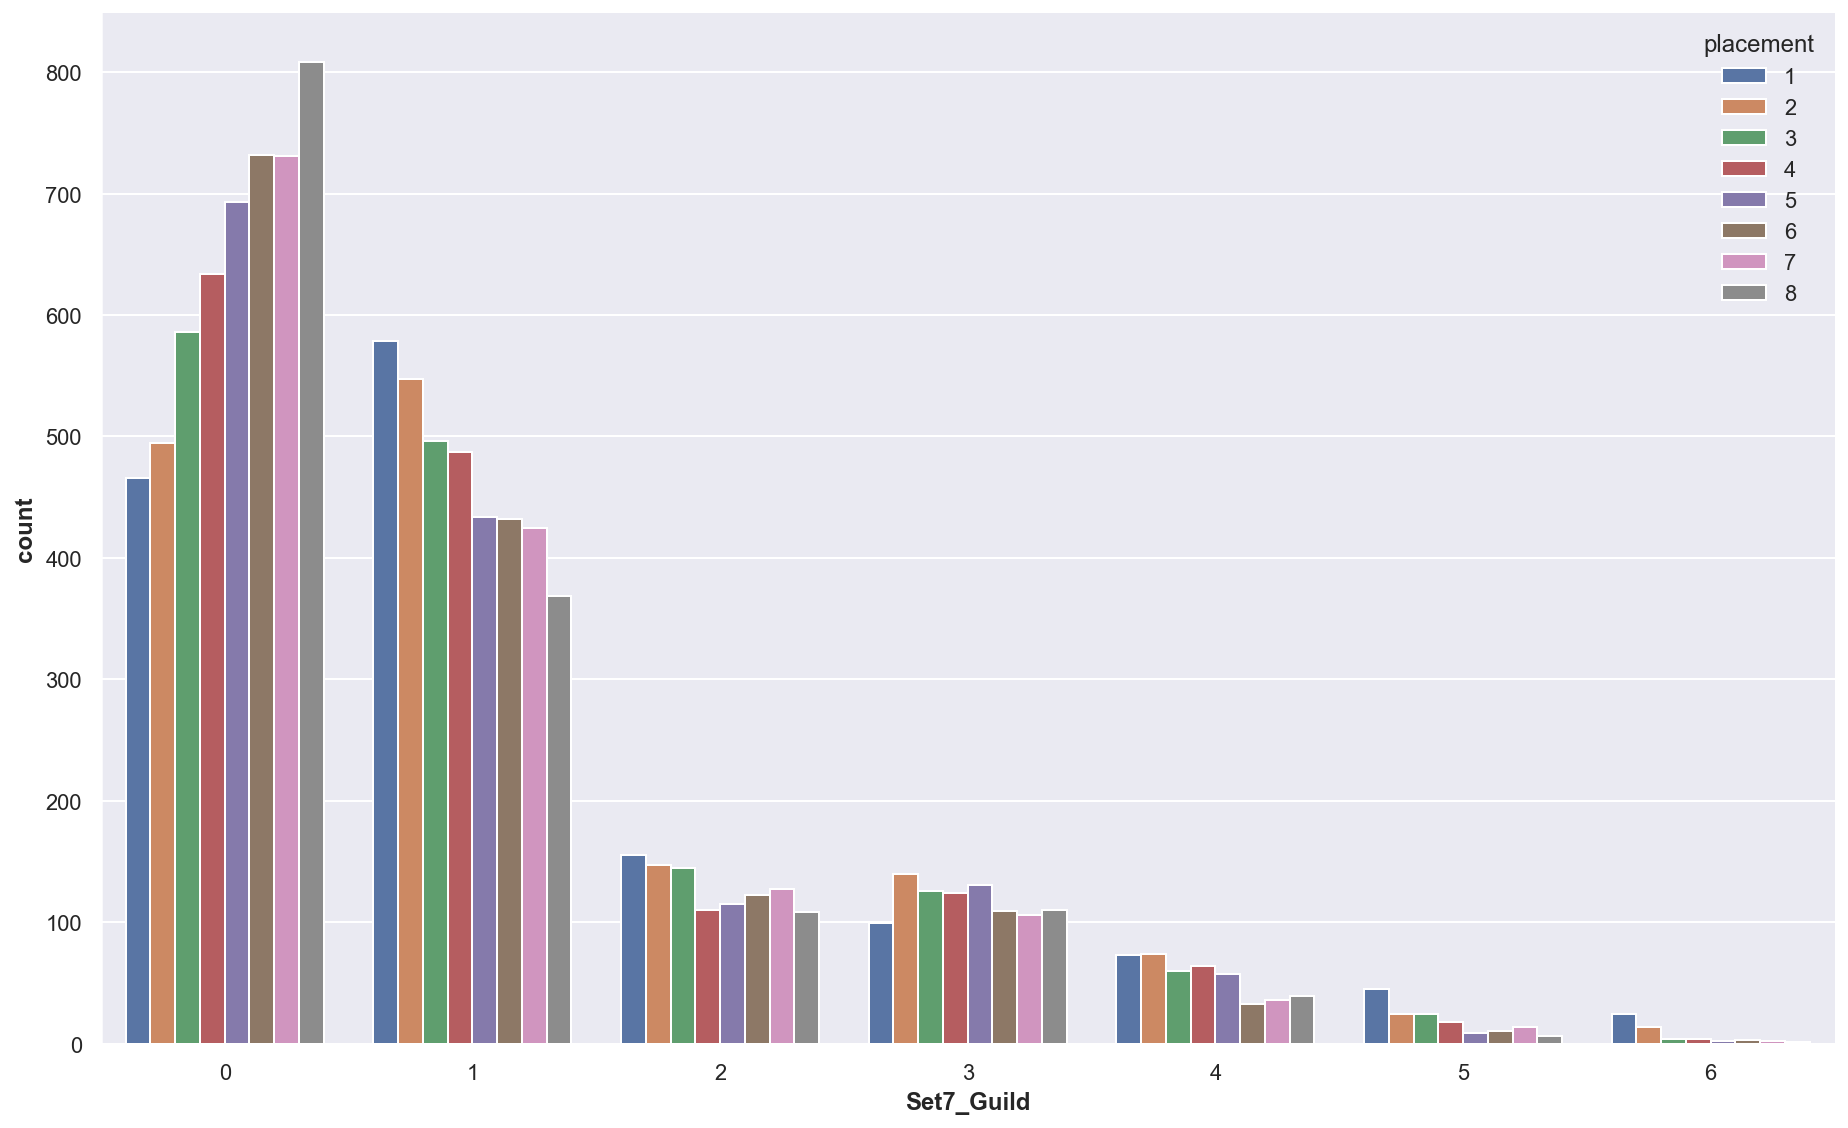

In [1110]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='Set7_Guild', hue=TARGETNAME)
sns.despine()

In [1111]:
# X[categorical_cols] = X[categorical_cols].applymap(np.int64)

In [1112]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

In [1113]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='mae', 
                    n_estimators=250) #, use_label_encoder=False hist tree_method='hist', enable_categorical=True,

In [1114]:
le_target = LabelEncoder()

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
augment_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
item_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
preproc = StandardScaler()

# Encode label.
# y = le_target.fit_transform(y)

In [1115]:
# augment_oe.fit(X[categorical_cols[:3]])

In [1116]:
# item_oe.fit(X[categorical_cols[3:]])

In [1117]:
# categorical_cols[3:]

In [1118]:
# Encode category columns.
logistic_regression_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("one_hot_time", one_hot_encoder, categorical_cols),
            # ("augment", augment_oe, categorical_cols[:3]),
            # ("item", item_oe, categorical_cols[3:]),
        ],
        remainder=preproc,
        verbose_feature_names_out=False,
    ),
    xgb,
)

In [1119]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.85, random_state=42)

logistic_regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('one_hot_time',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['augment0', 'augment1',
                                                   'augment2',
                                                   'TFT7_Shen_item0',
                                                   'TFT7_Shen_item1',
                                                   'TFT7_Twitch_item0',
                                                   'TFT7_Talon_item0',
                                                   'TFT7_Talon_item1',
                                                   'TFT7_Talon_item2',
                                                   'TFT7_Xayah_item0',
                                                   'TFT7_Xayah_item1',
                                                   '...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=250, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [1120]:
y_pred = logistic_regression_pipeline.predict(X_test)

In [1121]:
def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis = 1 ),
        'precision': cm / cm.sum(axis = 0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout = True, figsize = (20,6))
    ax = ax.flatten()
#     mask = (np.eye(cm.shape[0]) == 0) * 1
    for idx, (name, matrix) in enumerate(metrics.items()):
        ax[idx].set_title(name)
        sns.heatmap(
            data = matrix,
            cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar = False,
#             mask=mask,
            lw = 0.25,
            annot = True,
            fmt = '.2f',
            ax = ax[idx]
        )
#         for tick in ax[idx].get_xticklabels():
#                 tick.set_rotation(60)
                
    sns.despine()
    
def plot_cm_error(cm):
    mask = (np.eye(cm.shape[0]) != 0) * 1
    fig, ax = plt.subplots(tight_layout=True, figsize=(15,8))
    sns.heatmap(
                data = pd.DataFrame(data=cm, index=le_target.classes_, columns = le_target.classes_),
#                 cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
                cbar = False,
                lw = 0.25,
                mask = mask,
                annot = True,
                fmt = '.0f',
                ax = ax
            )
    plt.xticks(rotation=45)
    plt.tight_layout()
    sns.despine()

In [1122]:
# create confusion matrix, calculate accuracy,recall & precision
# cm = pd.DataFrame(data = confusion_matrix(le_target.inverse_transform(y_test), y_pred, labels = le_target.classes_), index = le_target.classes_, columns = le_target.classes_)
# plot_cm(cm)

In [1123]:
len(y_test)

1730

In [1124]:
y_pred.shape

(1730,)

In [1125]:
def plot_oof(y_true, y_predict):
    area = (30 * np.random.rand(len(y_predict)))**2 
    # Plot y_true vs. y_pred
    plt.figure(figsize=(10, 10))
    plt.scatter(y_true, y_predict, s=area, color='r', alpha=0.2)
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
    plt.gca().set_aspect('equal')
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.title('OOF Predictions')
    plt.show()

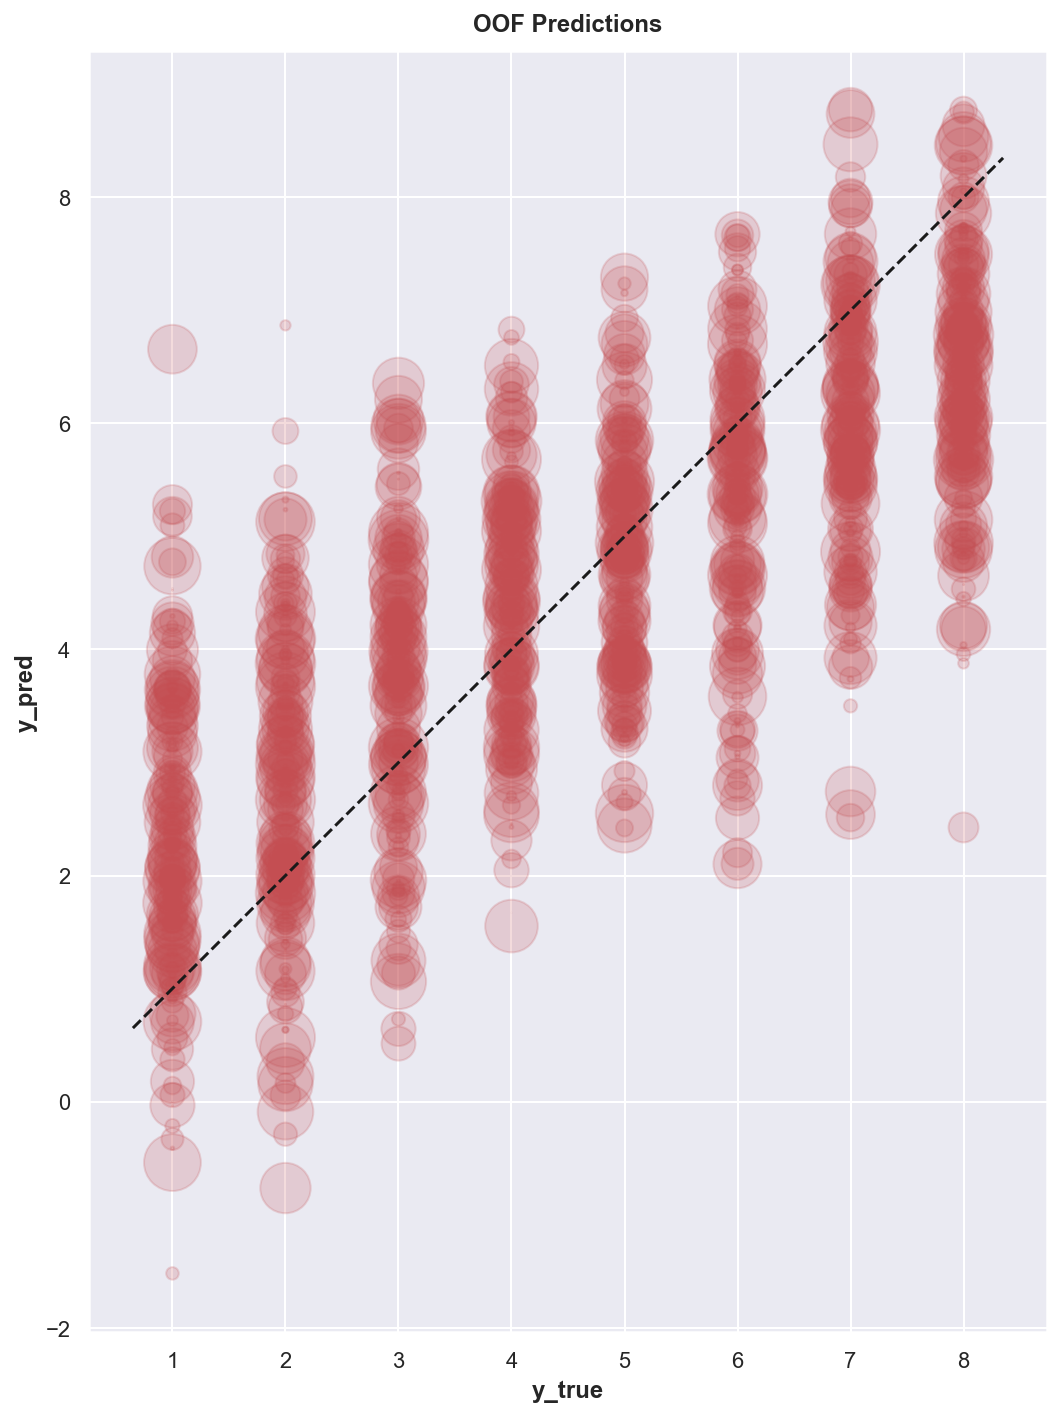

In [1126]:
plot_oof(y_test, y_pred)

In [1127]:
min(y_pred)

-1.5209378

In [1128]:
mean_absolute_error(y_test, y_pred)

1.1764328

In [1129]:
mean_squared_error(y_test, y_pred)

2.1761458

In [1130]:
feature_names = logistic_regression_pipeline[:-1].get_feature_names_out()
mdi_importances = pd.Series(
    logistic_regression_pipeline[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

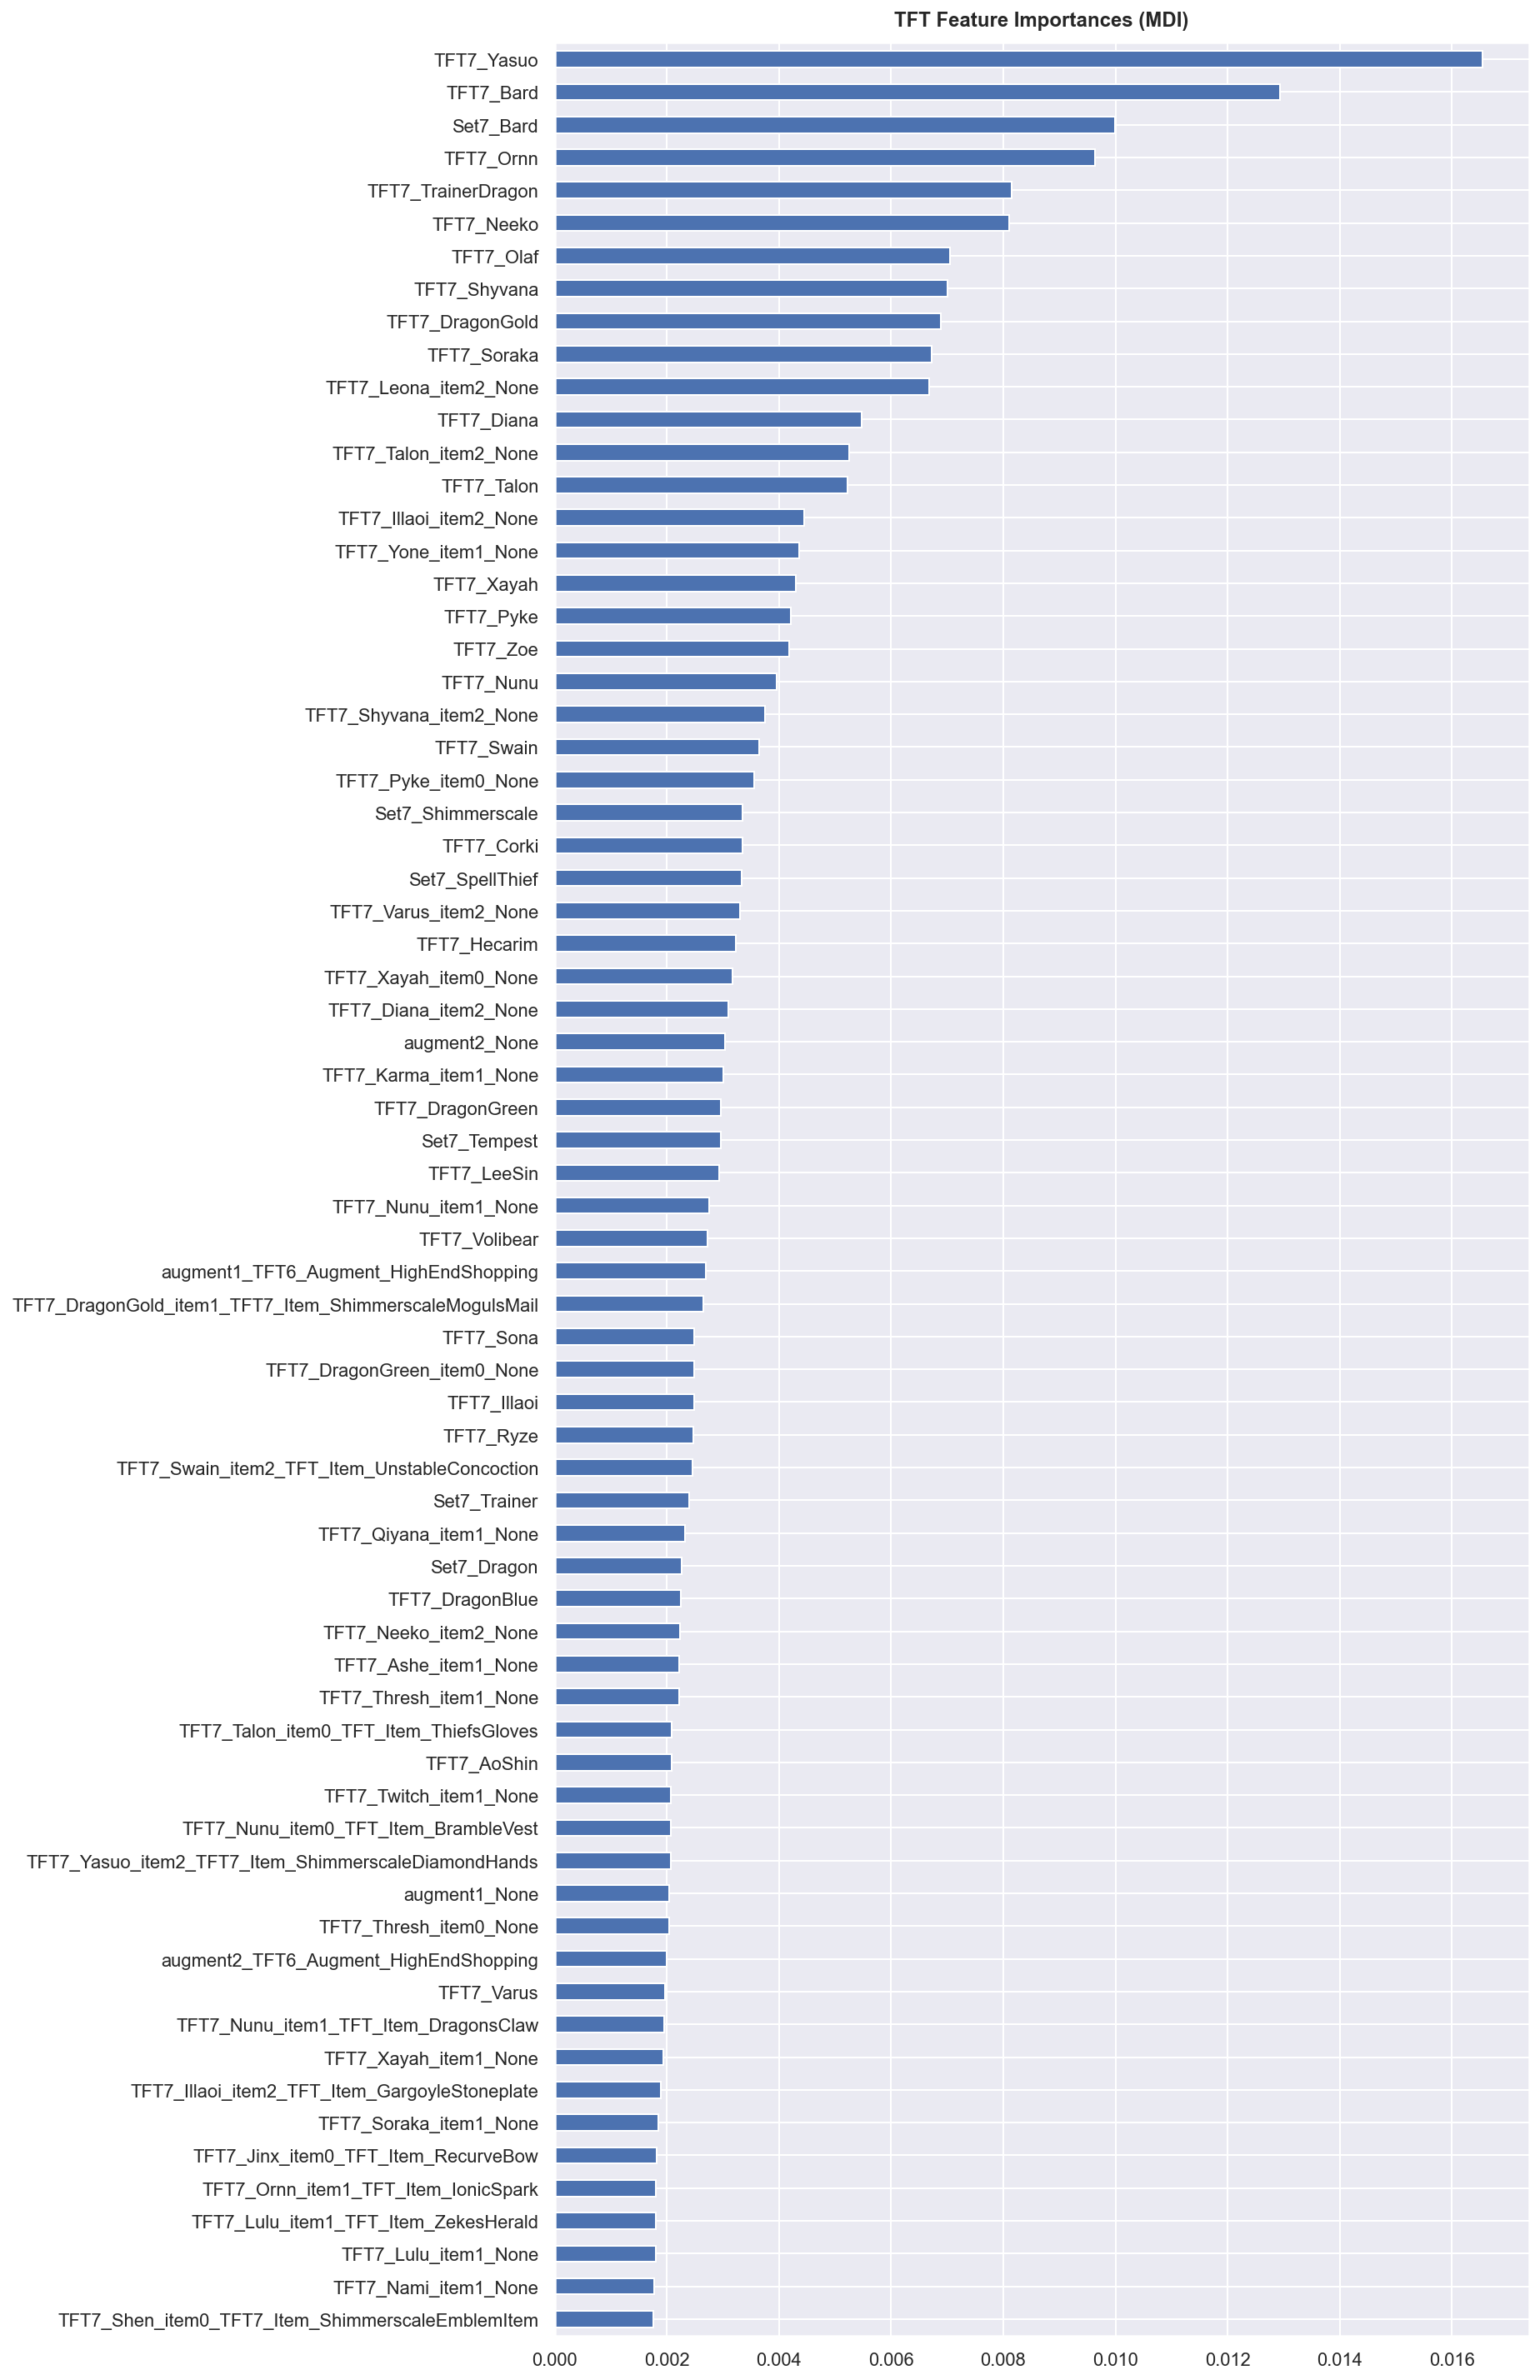

In [1131]:
plt.figure(figsize=(13, 20))
ax = mdi_importances[-70:].plot.barh()
ax.set_title("TFT Feature Importances (MDI)")
ax.figure.tight_layout()

In [1132]:
mdi_importances.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_mdi_importances.csv'))

In [1133]:
mdi_importances[-60:]

TFT7_Varus                                                0.001964
augment2_TFT6_Augment_HighEndShopping                     0.002002
TFT7_Thresh_item0_None                                    0.002042
augment1_None                                             0.002045
TFT7_Yasuo_item2_TFT7_Item_ShimmerscaleDiamondHands       0.002071
TFT7_Nunu_item0_TFT_Item_BrambleVest                      0.002075
TFT7_Twitch_item1_None                                    0.002078
TFT7_AoShin                                               0.002089
TFT7_Talon_item0_TFT_Item_ThiefsGloves                    0.002093
TFT7_Thresh_item1_None                                    0.002214
TFT7_Ashe_item1_None                                      0.002228
TFT7_Neeko_item2_None                                     0.002229
TFT7_DragonBlue                                           0.002257
Set7_Dragon                                               0.002271
TFT7_Qiyana_item1_None                                    0.00